In [1]:
import pandas as pd
import numpy as np
from IPython.display import Math #para escrever equações 
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, r2_score, mean_absolute_error, mean_squared_error
import statsmodels.api as sm
import seaborn as sns

import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

In [3]:
from random import randint
from xmlrpc.client import Boolean
from tqdm import tqdm
import pandas as pd
import numpy as np
import quantecon as qe

import logging
log = logging.getLogger(__name__)
# logging.basicConfig(level=logging.DEBUG) 


In [4]:
RANDOM_SIZE   = 1000000
RANDOM_SIZE   = 2000
QTD_BINS      = 3
TEST_SIZE     = 0.05
RANDOM_STATE  = 2022

- https://raw.githubusercontent.com/fkfouri/vegetable_oil_mkt/master/dataset/__by_month_commodity_types.csv
- https://raw.githubusercontent.com/fkfouri/vegetable_oil_mkt/master/dataset/__by_month_vegetable_oil.csv
- https://raw.githubusercontent.com/fkfouri/vegetable_oil_mkt/master/dataset/__by_month_full.csv

# Mercado de Oleo

## Dataset Completo
USDA por comodity
USDA Agrupado por Oleo Vegetal
OECD Agrupado
FAO Index Price


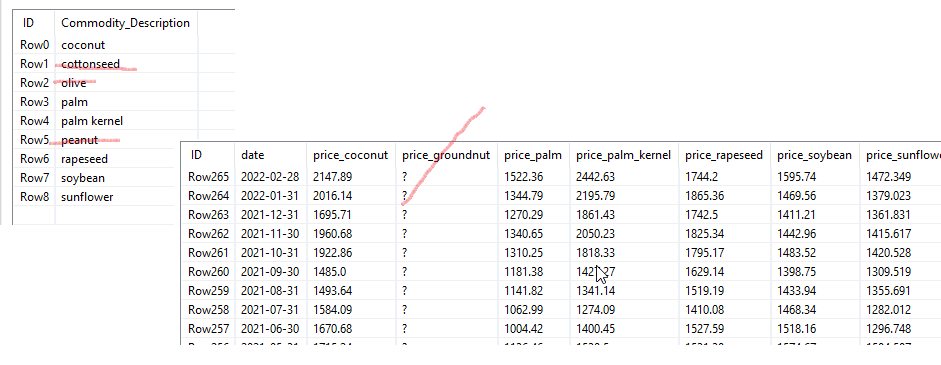

In [5]:

def get_dataset():
    df = pd.read_csv('https://raw.githubusercontent.com/fkfouri/vegetable_oil_mkt/master/dataset/__by_month_full.csv')
    print(df.shape)
    df['date'] = pd.to_datetime(df['date'])
    df.sort_values(by=['date'], ascending=[True], inplace=True)
    df.set_index(['date'], inplace=True)
    return df

%time df_full = get_dataset()
df_full.head()

(266, 139)
CPU times: total: 62.5 ms
Wall time: 533 ms


,reference,price_index_fao,coconut_beginning-stocks,coconut_crush,coconut_domestic-consumption,coconut_ending-stocks,coconut_exports,coconut_feed-waste-dom-cons,coconut_food-use-dom-cons,coconut_imports,...,vegetable-oil_total-supply_usda,vegetable-oils_consumption_oecd,vegetable-oils_ending-stocks_oecd,vegetable-oils_exports_oecd,vegetable-oils_food-fat-availability_oecd,vegetable-oils_food_oecd,vegetable-oils_human-consumption-per-capita_oecd,vegetable-oils_imports_oecd,vegetable-oils_other-use_oecd,vegetable-oils_production_oecd
date,,,,,,,,,,,,,,,,,,,,,
2000-01-31,NaN,48.583,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,7273.770,844.920,2541.320,2.240,6179.990,1.020,2490.870,1088.770,7469.760
2000-02-29,NaN,46.368,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,7298.970,849.930,2562.660,2.240,6190.320,1.020,2504.980,1098.620,7494.420
2000-03-31,NaN,47.819,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,7324.160,854.950,2584.010,2.240,6200.660,1.020,2519.100,1108.460,7519.090
2000-04-30,NaN,49.499,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,7349.360,859.960,2605.360,2.240,6211.000,1.030,2533.210,1118.310,7543.750
2000-05-31,NaN,44.489,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,7374.550,864.970,2626.710,2.250,6221.340,1.030,2547.320,1128.150,7568.420


In [6]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 266 entries, 2000-01-31 to 2022-02-28
Columns: 138 entries, reference to vegetable-oils_production_oecd
dtypes: float64(137), object(1)
memory usage: 288.9+ KB


In [7]:
df_full.dtypes

reference                                            object
price_index_fao                                     float64
coconut_beginning-stocks                            float64
coconut_crush                                       float64
coconut_domestic-consumption                        float64
                                                     ...   
vegetable-oils_food_oecd                            float64
vegetable-oils_human-consumption-per-capita_oecd    float64
vegetable-oils_imports_oecd                         float64
vegetable-oils_other-use_oecd                       float64
vegetable-oils_production_oecd                      float64
Length: 138, dtype: object

In [8]:
features = [x for x in df_full.columns if ('exports' in x or 'production' in x or 'price' in x) and not ('olive' in x or 'cottonseed' in x) ]
prices = [x for x in df_full.columns if 'price' in x and 'groundnut' not in x  ]
print(len(features), features)
print(len(prices), prices)

26 ['price_index_fao', 'coconut_exports', 'coconut_price', 'coconut_production', 'palm-kernel_exports', 'palm-kernel_price', 'palm-kernel_production', 'palm_exports', 'palm_price', 'palm_production', 'peanut_exports', 'peanut_price', 'peanut_production', 'rapeseed_exports', 'rapeseed_price', 'rapeseed_production', 'soybean_exports', 'soybean_price', 'soybean_production', 'sunflower_exports', 'sunflower_price', 'sunflower_production', 'vegetable-oil_exports_usda', 'vegetable-oil_production_usda', 'vegetable-oils_exports_oecd', 'vegetable-oils_production_oecd']
8 ['price_index_fao', 'coconut_price', 'palm-kernel_price', 'palm_price', 'peanut_price', 'rapeseed_price', 'soybean_price', 'sunflower_price']


In [9]:
df = df_full[features]
print(df.shape)
df = df[df['sunflower_production'].notnull()]
df = df[df['sunflower_price'].notnull()]
print(df.shape)
df

(266, 26)
(234, 26)


,price_index_fao,coconut_exports,coconut_price,coconut_production,palm-kernel_exports,palm-kernel_price,palm-kernel_production,palm_exports,palm_price,palm_production,...,soybean_exports,soybean_price,soybean_production,sunflower_exports,sunflower_price,sunflower_production,vegetable-oil_exports_usda,vegetable-oil_production_usda,vegetable-oils_exports_oecd,vegetable-oils_production_oecd
date,,,,,,,,,,,,,,,,,,,,,
2002-02-28,47.786,148.440,376.000,255.940,130.470,356.000,264.710,1527.920,352.980,2146.310,...,1186.220,364.920,3204.320,166.180,578.000,620.920,3312.180,8559.630,2986.310,7954.130
2002-03-31,47.622,148.040,366.000,255.830,130.830,353.240,266.520,1543.880,359.000,2162.830,...,1196.170,359.210,3222.400,168.850,557.000,625.580,3339.800,8591.720,3014.280,7983.170
2002-04-30,48.969,147.640,411.000,255.720,131.190,405.000,268.330,1559.830,360.070,2179.360,...,1206.110,370.860,3240.470,171.530,552.000,630.250,3367.440,8623.810,3042.260,8012.210
2002-05-31,51.641,147.240,420.000,255.610,131.560,418.300,270.150,1575.790,384.910,2195.890,...,1216.060,399.890,3258.550,174.200,574.000,634.920,3395.080,8655.950,3070.240,8041.250
2002-06-30,55.804,146.830,446.000,255.500,131.920,439.000,271.960,1591.750,426.130,2212.420,...,1226.000,456.810,3276.620,176.880,595.000,639.580,3422.710,8688.040,3098.220,8070.290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-31,165.862,157.080,1493.640,290.610,276.780,1341.140,716.470,4092.220,1141.820,6229.440,...,1659.830,1433.940,6354.170,988.220,1355.691,1703.690,7821.270,18894.320,7325.470,18174.560
2021-09-30,168.571,158.080,1485.000,291.080,278.380,1427.270,718.600,4103.190,1181.380,6246.960,...,1662.290,1398.750,6350.750,994.670,1309.519,1717.600,7837.790,18923.870,7328.510,18207.820
2021-10-31,184.837,159.080,1922.860,291.560,279.970,1818.330,720.740,4114.150,1310.250,6264.470,...,1664.750,1483.520,6347.330,1001.110,1420.528,1731.510,7854.300,18953.420,7331.560,18241.070


In [10]:
df.describe()

,price_index_fao,coconut_exports,coconut_price,coconut_production,palm-kernel_exports,palm-kernel_price,palm-kernel_production,palm_exports,palm_price,palm_production,...,soybean_exports,soybean_price,soybean_production,sunflower_exports,sunflower_price,sunflower_production,vegetable-oil_exports_usda,vegetable-oil_production_usda,vegetable-oils_exports_oecd,vegetable-oils_production_oecd
count,234.000,234.000,234.000,234.000,234.000,234.000,234.000,234.000,234.000,234.000,...,234.000,234.000,234.000,234.000,234.000,234.000,234.000,234.000,234.000,234.000
mean,103.046,154.793,1037.208,277.760,233.840,956.092,523.365,3226.635,763.075,4406.418,...,1417.502,882.535,4857.446,563.021,966.043,1174.819,5990.575,14277.728,5545.769,13471.372
std,32.741,10.334,412.612,12.313,41.691,378.930,139.269,805.918,244.906,1262.844,...,146.076,272.357,980.073,284.888,334.951,331.668,1329.965,3166.837,1307.176,3118.232
min,47.622,123.000,366.000,248.500,130.470,353.240,264.710,1527.920,352.980,2146.310,...,1138.080,359.210,3204.320,166.180,543.000,620.920,3312.180,8559.630,2986.310,7954.130
25%,78.436,148.055,702.250,270.998,219.213,655.290,399.255,2515.020,577.495,3275.315,...,1291.972,719.372,4057.825,329.412,719.643,886.732,5027.562,11538.903,4463.065,10815.903
50%,97.910,154.895,953.500,275.410,245.990,878.330,530.115,3399.860,732.000,4468.605,...,1424.230,832.990,4667.785,493.780,856.470,1127.385,5927.510,14325.960,5663.720,13418.630
75%,121.403,160.400,1387.287,287.767,263.450,1232.705,642.967,4014.682,886.188,5503.118,...,1542.398,1016.713,5831.602,867.900,1174.505,1528.378,7278.573,17158.577,6772.868,16394.708
max,184.837,177.920,2256.000,302.500,283.170,2307.630,725.000,4325.500,1377.220,6299.500,...,1669.670,1574.670,6381.500,1122.670,2045.000,1761.580,7887.340,19012.500,7349.260,18307.580


## Correlação

Paired density and scatterplot matrix

https://seaborn.pydata.org/examples/pair_grid_with_kde.html

In [11]:
if False:
    %time
    sns.set_theme(style="white")

    g = sns.PairGrid(df, diag_sharey=False)
    g.map_upper(sns.scatterplot, s=15)
    g.map_lower(sns.kdeplot)
    g.map_diag(sns.kdeplot, lw=2)

![Alt text](https://raw.githubusercontent.com/fkfouri/vegetable_oil_mkt/master/images/Compare.png)

## Dendograma

In [12]:
if False:
    plt.figure(figsize=(25,10))
    dendrogram = sch.dendrogram(sch.linkage(df, method  = "ward"))

    plt.title('Dendrogram')

    # plt.xlabel('Customers')
    plt.ylabel('Euclidean distances')
    %time plt.show()

# Markov
Observaçoes:
- Sera que o outcome deveria ser calculado em funcao do dado? Não deveria ser uma referencia Exogena? Exemplos (Open Interest da soja eu tenho). No exemplo do VIRAL... ele pega o outcome como o volume de negocios.

In [13]:
!pip install --upgrade quantecon numba tqdm

In [14]:
df.tail()

,price_index_fao,coconut_exports,coconut_price,coconut_production,palm-kernel_exports,palm-kernel_price,palm-kernel_production,palm_exports,palm_price,palm_production,...,soybean_exports,soybean_price,soybean_production,sunflower_exports,sunflower_price,sunflower_production,vegetable-oil_exports_usda,vegetable-oil_production_usda,vegetable-oils_exports_oecd,vegetable-oils_production_oecd
date,,,,,,,,,,,,,,,,,,,,,
2021-08-31,165.862,157.080,1493.640,290.610,276.780,1341.140,716.470,4092.220,1141.820,6229.440,...,1659.830,1433.940,6354.170,988.220,1355.691,1703.690,7821.270,18894.320,7325.470,18174.560
2021-09-30,168.571,158.080,1485.000,291.080,278.380,1427.270,718.600,4103.190,1181.380,6246.960,...,1662.290,1398.750,6350.750,994.670,1309.519,1717.600,7837.790,18923.870,7328.510,18207.820
2021-10-31,184.837,159.080,1922.860,291.560,279.970,1818.330,720.740,4114.150,1310.250,6264.470,...,1664.750,1483.520,6347.330,1001.110,1420.528,1731.510,7854.300,18953.420,7331.560,18241.070
2021-11-30,184.555,160.080,1960.680,292.030,281.570,2050.230,722.870,4125.120,1340.650,6281.990,...,1667.210,1442.960,6343.920,1007.560,1415.617,1745.420,7870.820,18982.970,7334.600,18274.330
2021-12-31,178.505,161.080,1695.710,292.500,283.170,1861.430,725.000,4136.080,1270.290,6299.500,...,1669.670,1411.210,6340.500,1014.000,1361.831,1759.330,7887.340,19012.500,7337.650,18307.580


## Geração do Random Sets

In [15]:
def prepare_dataset(df: pd.DataFrame):
    df = df.copy()
    for col in df.columns:
        df[f'{col}_delta']    = df[col].diff()
        df[f'{col}_outcome']  = df[col].diff(-1) * -1
        df[f'{col}_mom']      = df[col].pct_change()

    columns = sorted(list(df.columns))
    return df[columns].reset_index()


df_m = prepare_dataset(df)
df_m.tail(10).T

,224,225,226,227,228,229,230,231,232,233
date,2021-03-31 00:00:00,2021-04-30 00:00:00,2021-05-31 00:00:00,2021-06-30 00:00:00,2021-07-31 00:00:00,2021-08-31 00:00:00,2021-09-30 00:00:00,2021-10-31 00:00:00,2021-11-30 00:00:00,2021-12-31 00:00:00
coconut_exports,152.080,153.080,154.080,155.080,156.080,157.080,158.080,159.080,160.080,161.080
coconut_exports_delta,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
coconut_exports_mom,0.007,0.007,0.007,0.006,0.006,0.006,0.006,0.006,0.006,0.006
coconut_exports_outcome,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,NaN
...,...,...,...,...,...,...,...,...,...,...
vegetable-oils_exports_oecd_outcome,3.050,3.040,3.050,3.040,3.050,3.040,3.050,3.040,3.050,NaN
vegetable-oils_production_oecd,18008.290,18041.550,18074.800,18108.060,18141.310,18174.560,18207.820,18241.070,18274.330,18307.580
vegetable-oils_production_oecd_delta,33.250,33.260,33.250,33.260,33.250,33.250,33.260,33.250,33.260,33.250
vegetable-oils_production_oecd_mom,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002


In [16]:
df_m.tail()

,date,coconut_exports,coconut_exports_delta,coconut_exports_mom,coconut_exports_outcome,coconut_price,coconut_price_delta,coconut_price_mom,coconut_price_outcome,coconut_production,...,vegetable-oil_production_usda_mom,vegetable-oil_production_usda_outcome,vegetable-oils_exports_oecd,vegetable-oils_exports_oecd_delta,vegetable-oils_exports_oecd_mom,vegetable-oils_exports_oecd_outcome,vegetable-oils_production_oecd,vegetable-oils_production_oecd_delta,vegetable-oils_production_oecd_mom,vegetable-oils_production_oecd_outcome
229,2021-08-31,157.080,1.000,0.006,1.000,1493.640,-90.450,-0.057,-8.640,290.610,...,0.002,29.550,7325.470,3.050,0.000,3.040,18174.560,33.250,0.002,33.260
230,2021-09-30,158.080,1.000,0.006,1.000,1485.000,-8.640,-0.006,437.860,291.080,...,0.002,29.550,7328.510,3.040,0.000,3.050,18207.820,33.260,0.002,33.250
231,2021-10-31,159.080,1.000,0.006,1.000,1922.860,437.860,0.295,37.820,291.560,...,0.002,29.550,7331.560,3.050,0.000,3.040,18241.070,33.250,0.002,33.260
232,2021-11-30,160.080,1.000,0.006,1.000,1960.680,37.820,0.020,-264.970,292.030,...,0.002,29.530,7334.600,3.040,0.000,3.050,18274.330,33.260,0.002,33.250
233,2021-12-31,161.080,1.000,0.006,NaN,1695.710,-264.970,-0.135,NaN,292.500,...,0.002,NaN,7337.650,3.050,0.000,NaN,18307.580,33.250,0.002,NaN


In [17]:
def get_random_sets(input_dataframe: pd.DataFrame, 
                    size = 100000,
                    **kwargs):
    
    # take random sets of sequential rows 
    new_set = []

    # breakpoint()
    
    log.debug(f'AQUI:   {size}')
    for row_set in (tqdm(iterable = range(0, size), bar_format='{desc:<15}{percentage:3.0f}%|{bar:50}{r_bar}' ) ):
        
        # obtem de forma randomica uma amostra de n linhas do dataset
        # entre 3 e 18 meses
        row_quant     = randint(3, 18)
        row_start     = randint(0, len(input_dataframe) - row_quant)
        row_finish    = row_start + row_quant
        
        market_subset = input_dataframe.iloc[row_start:row_finish]

        # log.debug(f'AQUI:   {row_start} |{row_finish} | {market_subset.shape}')
        
        Close_Date    = max(market_subset['date'])
        

        if row_set%(size//5)==0:
            pass
            print(f'row_set: {row_set:<6} | row_quant: {row_quant:2} | rows: {row_start:>6}-{row_finish-1:<6} | market_subset: {str(market_subset.shape):^10} | Close_Date: {Close_Date:%m/%d/%Y}')
        
        ref = {}
        ref['Sequence_ID']  = [row_set]*len(market_subset)          # poderia ser 'row_quant' ao inves de 'len(market_subset)'
        ref['Close_Date']   = [Close_Date]*len(market_subset)
        ref['ref_date']   = market_subset['date']
        
        columns_ref = {}
        
        if 'columns' in kwargs and isinstance(kwargs['columns'], list):
            for _col in kwargs['columns']:
                if _col in input_dataframe.columns:
                    columns_ref[_col] = market_subset[_col]
                    columns_ref[f'{_col}_variation'] = market_subset[_col].pct_change()
                    
                    if 'outcomes' in kwargs and isinstance(kwargs['outcomes'], list) and _col in kwargs['outcomes']:
                        columns_ref[f'{_col}_outcome'] = market_subset[_col].diff(-1) * -1
            
        
        if 'bypass' in kwargs and isinstance(kwargs['bypass'], list):
            for _col in kwargs['bypass']:
                columns_ref[_col] = market_subset[_col]
               
        # columns_ref = dict( sorted(columns_ref.items(), key=lambda x: x[0].lower()) )
        
        #merge dictionaries
        ref = {**ref, **columns_ref}
        
        new_set.append(pd.DataFrame(ref))
        
    return new_set

# get_random_sets(df_m, RANDOM_SIZE)

In [18]:
%time my_set_case1 = get_random_sets(df.reset_index(), RANDOM_SIZE,columns=features,  outcomes=features, bypass=[])

                 0%|                                                  | 3/2000 [00:00<01:21, 24.59it/s]

row_set: 0      | row_quant: 15 | rows:    208-222    | market_subset:  (15, 27)  | Close_Date: 01/31/2021


                20%|██████████▎                                       | 410/2000 [00:06<00:25, 62.41it/s]

row_set: 400    | row_quant:  8 | rows:     69-76     | market_subset:  (8, 27)   | Close_Date: 11/30/2008


                40%|████████████████████▏                             | 809/2000 [00:12<00:19, 62.25it/s]

row_set: 800    | row_quant:  7 | rows:     14-20     | market_subset:  (7, 27)   | Close_Date: 03/31/2004


                60%|██████████████████████████████▏                   | 1208/2000 [00:19<00:12, 64.12it/s]

row_set: 1200   | row_quant: 14 | rows:    155-168    | market_subset:  (14, 27)  | Close_Date: 07/31/2016


                80%|████████████████████████████████████████▏         | 1607/2000 [00:25<00:06, 62.64it/s]

row_set: 1600   | row_quant: 13 | rows:    120-132    | market_subset:  (13, 27)  | Close_Date: 07/31/2013


               100%|██████████████████████████████████████████████████| 2000/2000 [00:31<00:00, 63.17it/s]

CPU times: total: 31.9 s
Wall time: 31.7 s


In [19]:
def convet_collection_to_dataframe(collection):
    """
    Concatena todas as colecoes
    Remove os np.inf e np.nan, gerados pelo pc_c
    """
    df_out = pd.concat(collection)
    
    log.debug(f'Before dropping NaNs: {df_out.shape}')
    df_out.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_out = df_out.dropna(how='any') 
    log.debug(f'After dropping NaNs: {df_out.shape}')
    return df_out

In [20]:
%time df1 = convet_collection_to_dataframe(my_set_case1)
df1

CPU times: total: 250 ms
Wall time: 249 ms


,Sequence_ID,Close_Date,ref_date,price_index_fao,price_index_fao_variation,price_index_fao_outcome,coconut_exports,coconut_exports_variation,coconut_exports_outcome,coconut_price,...,vegetable-oil_exports_usda_outcome,vegetable-oil_production_usda,vegetable-oil_production_usda_variation,vegetable-oil_production_usda_outcome,vegetable-oils_exports_oecd,vegetable-oils_exports_oecd_variation,vegetable-oils_exports_oecd_outcome,vegetable-oils_production_oecd,vegetable-oils_production_oecd_variation,vegetable-oils_production_oecd_outcome
209,0,2021-01-31,2019-12-31,101.499,0.089,7.234,156.000,-0.012,-0.580,1031.290,...,-15.090,18633.740,0.001,2.030,7161.350,-0.002,11.650,17681.190,0.000,18.940
210,0,2021-01-31,2020-01-31,108.733,0.071,-11.180,155.420,-0.004,-0.570,1003.720,...,-15.110,18635.770,0.000,2.020,7173.000,0.002,11.640,17700.130,0.001,18.950
211,0,2021-01-31,2020-02-29,97.553,-0.103,-12.128,154.850,-0.004,-0.580,844.120,...,-15.090,18637.790,0.000,2.010,7184.640,0.002,11.650,17719.080,0.001,18.940
212,0,2021-01-31,2020-03-31,85.425,-0.124,-4.247,154.270,-0.004,-0.580,837.720,...,-15.130,18639.800,0.000,2.040,7196.290,0.002,11.650,17738.020,0.001,18.950
213,0,2021-01-31,2020-04-30,81.178,-0.050,-3.409,153.690,-0.004,-0.570,834.510,...,-15.080,18641.840,0.000,2.020,7207.940,0.002,11.640,17756.970,0.001,18.940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,1999,2003-07-31,2003-02-28,62.353,-0.031,-3.119,145.140,0.002,0.360,477.000,...,25.900,8977.000,0.005,48.170,3298.110,0.005,16.020,8329.140,0.005,42.310
8,1999,2003-07-31,2003-03-31,59.234,-0.050,0.333,145.500,0.002,0.360,441.000,...,25.950,9025.170,0.005,48.160,3314.130,0.005,16.010,8371.450,0.005,42.310
9,1999,2003-07-31,2003-04-30,59.567,0.006,1.525,145.860,0.002,0.360,421.000,...,25.900,9073.330,0.005,48.180,3330.140,0.005,16.010,8413.760,0.005,42.310
10,1999,2003-07-31,2003-05-31,61.092,0.026,0.863,146.220,0.002,0.360,440.000,...,25.890,9121.510,0.005,48.170,3346.150,0.005,16.010,8456.070,0.005,42.300


In [21]:
outcomes = [x for x in df1.columns if 'outcome' in x  ]
outcomes

['price_index_fao_outcome',
 'coconut_exports_outcome',
 'coconut_price_outcome',
 'coconut_production_outcome',
 'palm-kernel_exports_outcome',
 'palm-kernel_price_outcome',
 'palm-kernel_production_outcome',
 'palm_exports_outcome',
 'palm_price_outcome',
 'palm_production_outcome',
 'peanut_exports_outcome',
 'peanut_price_outcome',
 'peanut_production_outcome',
 'rapeseed_exports_outcome',
 'rapeseed_price_outcome',
 'rapeseed_production_outcome',
 'soybean_exports_outcome',
 'soybean_price_outcome',
 'soybean_production_outcome',
 'sunflower_exports_outcome',
 'sunflower_price_outcome',
 'sunflower_production_outcome',
 'vegetable-oil_exports_usda_outcome',
 'vegetable-oil_production_usda_outcome',
 'vegetable-oils_exports_oecd_outcome',
 'vegetable-oils_production_oecd_outcome']

## Divisao em Quantis

In [22]:
get_divison = lambda size: [item / size for item in list(range(size + 1))]
get_labels = lambda size, start=0: [f'{chr( (item % 26 + start) + 65  )}{ "" if item // 26 <= 0 else item // 26 }' for item in list(range(size))]
get_full = lambda size: [ (chr(i + 65), f'{j / size} < x <= { (j+1) / size}' ) for i , j in enumerate(range(size))]
get_bins = lambda _input_array, size:  np.round(np.linspace(_input_array.min(), _input_array.max(), size + 1), 6).tolist()


def read_kwarg_list(kwargs, name, _else_conditions = None):
    if name in kwargs and isinstance(kwargs[name], list):
        return kwargs[name]
    return _else_conditions

def read_kwarg_bool(kwargs, name):
    if name in kwargs and isinstance(kwargs[name], Boolean):
        return kwargs[name]
    return False
        

In [23]:
get_labels(3, 10)

['K', 'L', 'M']

In [24]:
get_labels(3)

['A', 'B', 'C']

In [25]:
def quantiles_v1(df: pd.DataFrame, labels: list):
    df    = df.copy()
    ref   = ''.join(labels).lower()
    size  = len(labels)

    columns_labels = []
    for col in df.columns:
        if 'variation' in col:
            column_name         = f'{col}_qcut'
            df[column_name]     = pd.qcut(df[col], q=size, labels = labels)
            columns_labels.append(column_name)

    equation = ' + '.join( [f'df["{col}"].astype(str)' for col in columns_labels] )
    df['event_pattern']  = eval(equation) 
    columns_labels.append('event_pattern')

    return df
    return df[['Sequence_ID','Close_Date'] + columns_labels]
    

In [26]:
df2 = quantiles_v1(df1, ['L','M','H'])
print(df2.shape)
df2.tail()

(16332, 108)


,Sequence_ID,Close_Date,ref_date,price_index_fao,price_index_fao_variation,price_index_fao_outcome,coconut_exports,coconut_exports_variation,coconut_exports_outcome,coconut_price,...,soybean_price_variation_qcut,soybean_production_variation_qcut,sunflower_exports_variation_qcut,sunflower_price_variation_qcut,sunflower_production_variation_qcut,vegetable-oil_exports_usda_variation_qcut,vegetable-oil_production_usda_variation_qcut,vegetable-oils_exports_oecd_variation_qcut,vegetable-oils_production_oecd_variation_qcut,event_pattern
7,1999,2003-07-31,2003-02-28,62.353,-0.031,-3.119,145.140,0.002,0.360,477.000,...,L,L,M,L,H,H,H,M,H,LMLMHLHHMHHHHHLHMLLMLHHHMH
8,1999,2003-07-31,2003-03-31,59.234,-0.050,0.333,145.500,0.002,0.360,441.000,...,M,L,M,L,H,H,H,M,H,LMLMHLHHLHHHHHLHMMLMLHHHMH
9,1999,2003-07-31,2003-04-30,59.567,0.006,1.525,145.860,0.002,0.360,421.000,...,H,L,M,H,H,H,H,M,H,MMLMHLHHLHHHHHMHMHLMHHHHMH
10,1999,2003-07-31,2003-05-31,61.092,0.026,0.863,146.220,0.002,0.360,440.000,...,M,L,M,H,H,H,H,M,H,HMHMHMHHHHHHHHHHMMLMHHHHMH
11,1999,2003-07-31,2003-06-30,61.955,0.014,-3.116,146.580,0.002,0.360,459.000,...,M,L,M,H,H,H,H,M,H,MMHMHHHHHHHHHHMHMMLMHHHHMH


In [27]:
outcomes

['price_index_fao_outcome',
 'coconut_exports_outcome',
 'coconut_price_outcome',
 'coconut_production_outcome',
 'palm-kernel_exports_outcome',
 'palm-kernel_price_outcome',
 'palm-kernel_production_outcome',
 'palm_exports_outcome',
 'palm_price_outcome',
 'palm_production_outcome',
 'peanut_exports_outcome',
 'peanut_price_outcome',
 'peanut_production_outcome',
 'rapeseed_exports_outcome',
 'rapeseed_price_outcome',
 'rapeseed_production_outcome',
 'soybean_exports_outcome',
 'soybean_price_outcome',
 'soybean_production_outcome',
 'sunflower_exports_outcome',
 'sunflower_price_outcome',
 'sunflower_production_outcome',
 'vegetable-oil_exports_usda_outcome',
 'vegetable-oil_production_usda_outcome',
 'vegetable-oils_exports_oecd_outcome',
 'vegetable-oils_production_oecd_outcome']

## Compressing

In [28]:
def compress_v1(input_dataframe: pd.DataFrame, **kwargs):
    columns         = read_kwarg_list(kwargs,'columns')
    outcomes        = read_kwarg_list(kwargs,'outcomes')
    
    if columns and 'event_pattern' in input_dataframe.columns:
        df_step1 = input_dataframe.groupby(columns)['event_pattern'].apply(lambda x: ','.join(x)).reset_index()
        
    if columns and outcomes:
        df_step2 = input_dataframe.groupby(columns)[outcomes].mean()
        
    compressed_set = pd.merge(df_step1, df_step2, on= columns, how='inner')
    
    return compressed_set

In [29]:
df3 = compress_v1(df2, columns = ['Sequence_ID', 'Close_Date'],  outcomes = outcomes)
print(df3.shape)
df3.tail()

(1957, 29)


,Sequence_ID,Close_Date,event_pattern,price_index_fao_outcome,coconut_exports_outcome,coconut_price_outcome,coconut_production_outcome,palm-kernel_exports_outcome,palm-kernel_price_outcome,palm-kernel_production_outcome,...,soybean_exports_outcome,soybean_price_outcome,soybean_production_outcome,sunflower_exports_outcome,sunflower_price_outcome,sunflower_production_outcome,vegetable-oil_exports_usda_outcome,vegetable-oil_production_usda_outcome,vegetable-oils_exports_oecd_outcome,vegetable-oils_production_oecd_outcome
1952,1995,2009-02-28,"MLHLMMMMMHHHLHHHLMLHHHLLMM,HLMMMMMMLMHHLHHHLHL...",-9.976,-1.509,-92.111,-0.100,1.190,-96.361,2.002,...,-17.169,-76.692,-4.208,5.441,-128.556,9.181,7.073,39.638,14.893,33.950
1953,1996,2013-07-31,"HMMHHMHMHHLMMLHMHHMLHLMLML,MHLHHLHMLHLMMLMMHML...",-1.861,0.141,-17.464,-0.288,-0.323,-18.970,2.906,...,4.040,-20.765,15.307,6.342,-21.783,6.932,19.227,57.332,17.909,49.102
1954,1997,2013-02-28,"HMMHHMHMHHLMMLHMHHMLHLMLML,MHLHHLHMLHLMMLMMHML...",-1.858,0.296,-30.964,0.666,1.337,-32.454,3.007,...,6.971,-9.430,12.276,-0.200,-26.646,-1.887,24.007,42.553,21.039,39.930
1955,1998,2019-04-30,"LMLHLLHLLHMMMLLMLLLLMLLMLH,MHLMHLMMHMMLMMLLMMM...",-1.178,1.471,-48.877,0.078,1.281,-41.839,1.648,...,7.960,-8.339,13.279,9.568,-5.485,7.994,34.571,38.013,24.340,24.352
1956,1999,2003-07-31,"MMMMMMHHMHLLLLLLHLHHLMHMHM,HMHMMHHHMHLLLLMLHHH...",1.020,-0.100,6.636,0.365,1.038,5.583,2.866,...,9.073,15.655,14.502,3.796,1.636,8.662,39.101,56.919,33.082,50.683


In [30]:
df3.columns

Index(['Sequence_ID', 'Close_Date', 'event_pattern', 'price_index_fao_outcome',
       'coconut_exports_outcome', 'coconut_price_outcome',
       'coconut_production_outcome', 'palm-kernel_exports_outcome',
       'palm-kernel_price_outcome', 'palm-kernel_production_outcome',
       'palm_exports_outcome', 'palm_price_outcome', 'palm_production_outcome',
       'peanut_exports_outcome', 'peanut_price_outcome',
       'peanut_production_outcome', 'rapeseed_exports_outcome',
       'rapeseed_price_outcome', 'rapeseed_production_outcome',
       'soybean_exports_outcome', 'soybean_price_outcome',
       'soybean_production_outcome', 'sunflower_exports_outcome',
       'sunflower_price_outcome', 'sunflower_production_outcome',
       'vegetable-oil_exports_usda_outcome',
       'vegetable-oil_production_usda_outcome',
       'vegetable-oils_exports_oecd_outcome',
       'vegetable-oils_production_oecd_outcome'],
      dtype='object')

## Simplificando o Dataset
A rigor a simplificaçao ocorre antes de *Directions*, pois dá para remover dados indesejados.

In [31]:
df3[outcomes].describe()

,price_index_fao_outcome,coconut_exports_outcome,coconut_price_outcome,coconut_production_outcome,palm-kernel_exports_outcome,palm-kernel_price_outcome,palm-kernel_production_outcome,palm_exports_outcome,palm_price_outcome,palm_production_outcome,...,soybean_exports_outcome,soybean_price_outcome,soybean_production_outcome,sunflower_exports_outcome,sunflower_price_outcome,sunflower_production_outcome,vegetable-oil_exports_usda_outcome,vegetable-oil_production_usda_outcome,vegetable-oils_exports_oecd_outcome,vegetable-oils_production_oecd_outcome
count,1957.000,1957.000,1957.000,1957.000,1957.000,1957.000,1957.000,1957.000,1957.000,1957.000,...,1957.000,1957.000,1957.000,1957.000,1957.000,1957.000,1957.000,1957.000,1957.000,1957.000
mean,0.295,-0.018,4.840,0.126,0.606,2.755,1.873,10.598,2.036,17.329,...,1.951,2.192,14.397,3.239,2.737,4.067,18.981,44.702,18.937,44.188
std,3.794,1.485,55.638,0.925,1.203,57.674,1.532,13.274,29.724,13.176,...,10.256,27.595,11.467,7.185,41.814,7.641,18.458,21.700,14.729,24.663
min,-29.180,-3.120,-243.000,-1.830,-2.650,-336.930,-2.120,-24.320,-249.910,-22.310,...,-25.280,-193.555,-16.860,-15.500,-373.000,-14.100,-28.240,-9.230,-24.600,-17.335
25%,-1.387,-0.998,-21.025,-0.422,-0.418,-25.532,1.098,3.433,-10.715,13.110,...,-5.320,-10.226,9.368,-0.274,-10.293,0.540,7.765,30.640,11.646,31.116
50%,0.105,0.018,4.000,0.086,0.720,1.562,2.173,12.785,1.146,19.750,...,3.134,1.022,14.171,2.900,0.000,4.076,20.557,46.969,21.484,42.591
75%,1.731,0.737,30.333,0.850,1.422,30.154,2.895,19.891,13.911,24.171,...,8.770,13.000,19.277,8.200,11.917,9.231,30.608,61.014,28.530,61.173
max,15.540,4.130,270.500,2.270,2.940,267.570,6.525,55.800,133.205,57.615,...,30.570,113.220,54.005,17.910,240.000,19.660,95.850,120.400,91.940,108.275


In [32]:
# df3[[x for x in df_full.columns if 'outcome' in x and 'prices' in x  ]].describe()

In [33]:
relevant_cut_off  = 1 #variacao maior que 1 ponto 
outcome_reference = 'price_index_fao_outcome'

print(f'All available data: { df3.shape[0]}')
df4 = df3[ abs(df3[outcome_reference]) > relevant_cut_off ][:]
print(f'Relevant changes: { df4.shape[0]}')

All available data: 1957
Relevant changes: 1268


In [34]:
df4

,Sequence_ID,Close_Date,event_pattern,price_index_fao_outcome,coconut_exports_outcome,coconut_price_outcome,coconut_production_outcome,palm-kernel_exports_outcome,palm-kernel_price_outcome,palm-kernel_production_outcome,...,soybean_exports_outcome,soybean_price_outcome,soybean_production_outcome,sunflower_exports_outcome,sunflower_price_outcome,sunflower_production_outcome,vegetable-oil_exports_usda_outcome,vegetable-oil_production_usda_outcome,vegetable-oils_exports_oecd_outcome,vegetable-oils_production_oecd_outcome
0,0,2021-01-31,"HLHLLHLLHLMHHMMLHHMMMMLLLL,HLLMLMLLHLHLMMHMMHL...",1.855,-0.576,30.696,-0.139,-0.855,9.428,-0.930,...,0.570,12.760,11.681,-15.500,30.283,-14.097,-15.103,2.021,11.646,18.945
2,2,2008-02-29,"MHMHMMHHMHLHHLHMLHLLHLMMHM,HLHLHHMMHHHMLHHHLHL...",15.038,-3.120,114.500,-0.375,1.410,127.570,1.900,...,-25.280,113.220,-16.855,7.090,185.000,11.345,1.525,30.645,18.455,33.100
3,3,2020-12-31,MLHMLHLLHLHLMMMMMMLLMLLLLL,15.453,-0.580,250.590,-0.140,-0.860,267.570,-0.930,...,0.570,59.110,11.680,-15.500,127.710,-14.100,-15.110,2.010,11.650,18.940
4,4,2018-10-31,"MMLHMMHLLHMHMLHMLMLLMMLMLH,HMHHMHHLMHMMMLLMLHL...",-1.022,1.665,-54.253,0.919,1.335,-15.939,3.014,...,2.195,-5.601,9.981,4.467,-4.997,5.375,26.639,50.792,29.158,48.854
6,6,2016-04-30,"MLMLLHLLMLLMMLMLLMMMMMLLLL,HLHMLHLLHLLLMLHLLHM...",2.744,-0.254,75.623,0.157,-0.367,71.341,1.497,...,-5.829,10.533,14.226,12.413,-2.981,12.707,18.170,44.134,16.964,53.557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1952,1995,2009-02-28,"MLHLMMMMMHHHLHHHLMLHHHLLMM,HLMMMMMMLMHHLHHHLHL...",-9.976,-1.509,-92.111,-0.100,1.190,-96.361,2.002,...,-17.169,-76.692,-4.208,5.441,-128.556,9.181,7.073,39.638,14.893,33.950
1953,1996,2013-07-31,"HMMHHMHMHHLMMLHMHHMLHLMLML,MHLHHLHMLHLMMLMMHML...",-1.861,0.141,-17.464,-0.288,-0.323,-18.970,2.906,...,4.040,-20.765,15.307,6.342,-21.783,6.932,19.227,57.332,17.909,49.102
1954,1997,2013-02-28,"HMMHHMHMHHLMMLHMHHMLHLMLML,MHLHHLHMLHLMMLMMHML...",-1.858,0.296,-30.964,0.666,1.337,-32.454,3.007,...,6.971,-9.430,12.276,-0.200,-26.646,-1.887,24.007,42.553,21.039,39.930
1955,1998,2019-04-30,"LMLHLLHLLHMMMLLMLLLLMLLMLH,MHLMHLMMHMMLMMLLMMM...",-1.178,1.471,-48.877,0.078,1.281,-41.839,1.648,...,7.960,-8.339,13.279,9.568,-5.485,7.994,34.571,38.013,24.340,24.352


## Determinando vetores de direção


In [35]:
def directions(df: pd.DataFrame):
    df    = df.copy()

    for col in [x for x in df.columns if 'outcome' in x ]:
        column_name         = f'{col}_direction'
        df[column_name]     = df[col].apply(lambda x: 1 if x > 0 else 0 )

    columns_fixed   = list(df.columns[:4])
    columns_sort    = sorted(list(df.columns[4:]))
    return df[columns_fixed + columns_sort].sort_values(by = ['Close_Date'], ascending=[True])


In [36]:
#sem simplificacao
%time df5 = directions(df3)
df5

CPU times: total: 46.9 ms
Wall time: 40 ms


,Sequence_ID,Close_Date,event_pattern,price_index_fao_outcome,coconut_exports_outcome,coconut_exports_outcome_direction,coconut_price_outcome,coconut_price_outcome_direction,coconut_production_outcome,coconut_production_outcome_direction,...,sunflower_production_outcome,sunflower_production_outcome_direction,vegetable-oil_exports_usda_outcome,vegetable-oil_exports_usda_outcome_direction,vegetable-oil_production_usda_outcome,vegetable-oil_production_usda_outcome_direction,vegetable-oils_exports_oecd_outcome,vegetable-oils_exports_oecd_outcome_direction,vegetable-oils_production_oecd_outcome,vegetable-oils_production_oecd_outcome_direction
1324,1358,2002-05-31,"MMMMMMHHMHLLLLLLHLHHLMHMHM,HMHMMHHHMHLLLLMLHHH...",2.009,-0.400,0,27.000,1,-0.110,0,...,4.670,1,27.640,1,32.115,1,27.980,1,29.040,1
73,74,2002-06-30,HMMMMMHHHHLHLLMLHHHHHMHMHM,4.163,-0.410,0,26.000,1,-0.110,0,...,4.660,1,27.630,1,32.090,1,27.980,1,29.040,1
491,501,2002-06-30,HMMMMMHHHHLHLLMLHHHHHMHMHM,4.163,-0.410,0,26.000,1,-0.110,0,...,4.660,1,27.630,1,32.090,1,27.980,1,29.040,1
1648,1684,2003-01-31,"HMHMMHHHHHLHLLHLHHHHHMHMHM,HLMMMMHHHHLHLLHLHHH...",4.259,-1.025,0,24.000,1,0.025,1,...,17.805,1,95.850,1,120.400,1,91.940,1,108.275,1
1762,1800,2003-01-31,"HMHMMHHHMHLLLLMLHHHHMMHMHM,HMMMMMHHHHLHLLMLHHH...",3.838,-0.715,0,20.750,1,-0.042,0,...,11.235,1,61.742,1,76.258,1,59.960,1,68.658,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1450,1484,2021-10-31,"HLHMLHLLHLHHMMHMMHLLHLLLLL,HLLMLLLLHLHHMMHMMHL...",7.058,-0.576,0,90.514,1,-0.140,0,...,-14.098,0,-15.100,0,2.018,1,11.646,1,18.944,1
1085,1111,2021-10-31,"HLHMLHLLHLHHMMHMMHLLHLLLLL,HLLMLLLLHLHHMMHMMHL...",7.058,-0.576,0,90.514,1,-0.140,0,...,-14.098,0,-15.100,0,2.018,1,11.646,1,18.944,1
1348,1382,2021-11-30,"HLHMLHLLHLHMMMHMMHLLHLLLLL,HLHMLMLLHLHMMMMMMHL...",7.734,-0.577,0,129.217,1,-0.140,0,...,-14.100,0,-15.103,0,2.017,1,11.647,1,18.943,1
1707,1744,2021-11-30,MLHMLHLLHLHLMMMMMMLLMLLLLL,15.453,-0.580,0,250.590,1,-0.140,0,...,-14.100,0,-15.110,0,2.010,1,11.650,1,18.940,1


## Split Train/Test

O Shuffle esta desativado. Não sera realizado embaralhamento de serie temporal, para evitar o erro de prever o passado com dados do futuro.

In [37]:
feature_directions = ['event_pattern'] + [x for x in df5.columns if 'direction' in x ]

In [38]:
X = df5[ feature_directions ]
y = df5[['price_index_fao_outcome']]


In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=False)
print(f'X_train: {X_train.shape} | X_test: {X_test.shape} | y_train: {y_train.shape} | y_test: {y_test.shape} ')

X_train: (1859, 27) | X_test: (98, 27) | y_train: (1859, 1) | y_test: (98, 1) 


In [40]:
X_train

,event_pattern,coconut_exports_outcome_direction,coconut_price_outcome_direction,coconut_production_outcome_direction,palm-kernel_exports_outcome_direction,palm-kernel_price_outcome_direction,palm-kernel_production_outcome_direction,palm_exports_outcome_direction,palm_price_outcome_direction,palm_production_outcome_direction,...,soybean_exports_outcome_direction,soybean_price_outcome_direction,soybean_production_outcome_direction,sunflower_exports_outcome_direction,sunflower_price_outcome_direction,sunflower_production_outcome_direction,vegetable-oil_exports_usda_outcome_direction,vegetable-oil_production_usda_outcome_direction,vegetable-oils_exports_oecd_outcome_direction,vegetable-oils_production_oecd_outcome_direction
1324,"MMMMMMHHMHLLLLLLHLHHLMHMHM,HMHMMHHHMHLLLLMLHHH...",0,1,0,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
73,HMMMMMHHHHLHLLMLHHHHHMHMHM,0,1,0,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
491,HMMMMMHHHHLHLLMLHHHHHMHMHM,0,1,0,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1648,"HMHMMHHHHHLHLLHLHHHHHMHMHM,HLMMMMHHHHLHLLHLHHH...",0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1762,"HMHMMHHHMHLLLLMLHHHHMMHMHM,HMMMMMHHHHLHLLMLHHH...",0,1,0,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
890,"HLLMLMLLHLHLMMHMMHLLHLLLLL,LMLMLLLLLLHHMMLMMLL...",0,0,0,0,0,0,0,0,1,...,1,0,1,0,1,0,0,1,1,1
431,"MLMLLMLLMLMHHMMMHMMHHMLLLL,HLHLLHLLHLMHHMHLHHM...",0,1,0,0,1,0,0,1,0,...,1,1,1,0,1,0,0,1,1,1
1235,"LLMMLLLLLLHHMMLMMLLLLLLLLL,LLMMLHLLLLHHMMLMMLL...",0,1,0,0,0,0,0,1,1,...,1,1,1,0,1,0,0,1,1,1
1033,"HLLMLMLLHLHLMMHMMHLLHLLLLL,LMLMLLLLLLHHMMLMMLL...",0,0,0,0,0,0,0,0,1,...,1,0,1,0,1,0,0,1,1,1


In [41]:
print(X_train.shape, "Metade de linhas:", X_train.shape[0]/2)
print('=='*80)
print('Vou usar a referencia de "sunflower_production_outcome_direction" pois ele tem aproximadamente metade do shape e por ser o influenciado de mercado. ')
print('=='*80)

X_train[[x for x in df5.columns if 'direction' in x ]].sum()

(1859, 27) Metade de linhas: 929.5
Vou usar a referencia de "sunflower_production_outcome_direction" pois ele tem aproximadamente metade do shape e por ser o influenciado de mercado. 


coconut_exports_outcome_direction                    991
coconut_price_outcome_direction                      980
coconut_production_outcome_direction                1010
palm-kernel_exports_outcome_direction               1322
palm-kernel_price_outcome_direction                  928
palm-kernel_production_outcome_direction            1649
palm_exports_outcome_direction                      1579
palm_price_outcome_direction                         946
palm_production_outcome_direction                   1664
peanut_exports_outcome_direction                    1120
peanut_price_outcome_direction                       966
peanut_production_outcome_direction                 1118
price_index_fao_outcome_direction                    930
rapeseed_exports_outcome_direction                  1609
rapeseed_price_outcome_direction                     994
rapeseed_production_outcome_direction               1611
soybean_exports_outcome_direction                   1133
soybean_price_outcome_direction

In [42]:
direction_reference = 'sunflower_production_outcome_direction'
df6_pos_case1 = X_train.loc[X_train[direction_reference] > 0]
df6_neg_case1 = X_train.loc[X_train[direction_reference] <= 0]
print(f'df6_pos: {df6_pos_case1.shape} | df6_neg: {df6_neg_case1.shape}')

df6_pos: (1513, 27) | df6_neg: (346, 27)


## Unique Patterns

In [43]:
X_train_case1 = X_train.copy()

In [44]:
def get_unique_patterns_V1(input_array: np.ndarray, **kwargs):
    """ 
    Aqui o 'get_labels' nao deve fazer parte... pois os unique patterns pode estar agrupado. Ex. AAA, ABC, etc
    """
    flat_list = [ item.split(',') for item in input_array ]
    unique_patterns = ','.join(str(r) for v in flat_list for r in v)
    unique_patterns = sorted(list( set( unique_patterns.split(',') ) ))
    return unique_patterns

In [45]:
# flat_list = [ item.split(',') for item in X_train['event_pattern'].values ]
# unique_patterns = ','.join(str(r) for v in flat_list for r in v)
# unique_patterns = sorted(list( set( unique_patterns.split(',') ) ))
# unique_patterns

In [46]:
unique_patterns = get_unique_patterns_V1(X_train_case1['event_pattern'].values)
print(len(unique_patterns), unique_patterns[:3])

209 ['HHHHHHHHHHLLLLHHHHHLHLHHHH', 'HHHHMHHHHHLHHLHHLHLLHLMMHH', 'HHHHMHHHHHLHHLHMLHLLHLMMHM']


## Matriz de Markov

Matriz estocastica
- cada elemento da matriz é positivo
- a somatoria de cada linha é 1

In [47]:
def build_transition_grid_v1(input_dataframe: pd.DataFrame, unique_patterns):
    # log.debug(f'unique_patterns ==> {unique_patterns}')
    
    # build the markov transition grid

    patterns = []
    counts = []
    counts_fk = {}
    
    # de
    for from_event in unique_patterns:
        # para
        
        for to_event in unique_patterns:
            
            pattern = from_event + ',' + to_event # MMM,MlM
            

            ids_matches = input_dataframe[input_dataframe['event_pattern'].str.contains(pattern)]
            
            
            found = 0
            if len(ids_matches) > 0:
                Event_Pattern = '---'.join(ids_matches['event_pattern'].values)
                found = Event_Pattern.count(pattern)
                
#             log.debug(f'pattern => {pattern} | ids_matches: {len(ids_matches)} | found: {found} ')
            patterns.append(pattern)
            counts.append(found)
            
            counts_fk[pattern] = f'{len(ids_matches)}|{found}'
    
    # log.debug(f'patterns: {patterns}')
    # log.debug(f'counts: {counts}')
    # log.debug(counts_fk)

    # create to/from grid
    grid_Df = pd.DataFrame({'pairs':patterns, 'counts': counts})
    
    # return grid_Df

    ## Warning
    # grid_Df['x'], grid_Df['y'] = grid_Df['pairs'].str.split(',').str
    
    grid_Df[['x', 'y']] = grid_Df['pairs'].str.split(',', n=1, expand=True)
    
    # return grid_Df

    grid_Df = grid_Df.pivot(index='x', columns='y', values='counts')
    
    # return grid_Df

    # log.debug(f'Antes Columns :{grid_Df.columns}')
    grid_Df.columns= [col for col in grid_Df.columns]
    # log.debug(f'Depois Columns :{grid_Df.columns}')
    
    # return grid_Df
   

    # replace all NaN with zeros
    grid_Df.fillna(0, inplace=True)
    
    grid_Df['soma'] = grid_Df.sum(axis=1)
    
    # return grid_Df

    # grid_Df.rowSums(transition_dataframe) 
    # grid_Df = grid_Df / grid_Df['soma']
    
    for col in grid_Df.columns:
        grid_Df[col] = grid_Df[col]/grid_Df['soma']
        
        
    del grid_Df['soma']

    return grid_Df

In [48]:
%time grid_pos = build_transition_grid_v1(df6_pos_case1, unique_patterns) 
grid_pos.to_excel('grid_case1_pos.xlsx')
grid_pos

CPU times: total: 1min 12s
Wall time: 1min 13s


,HHHHHHHHHHLLLLHHHHHLHLHHHH,HHHHMHHHHHLHHLHHLHLLHLMMHH,HHHHMHHHHHLHHLHMLHLLHLMMHM,HHHHMHHHMHLHHLHHLHLLHLMMHH,HHHHMHMMHLMHLMMHHMHLHMMHLM,HHHHMHMMHLMLLMHHHHHMHMMHLM,HHHLLHHMHMMMMHHMLHLHHHMMMM,HHHMMHHHHHHLHMLLLMMHLHHHHH,HHHMMHHHHHHLHMMLLHMHMHHHHH,HHHMMHHHHHMHHMHLLHMHMHHHHH,...,MMLLMLMHMMHLMHMHMMHHMHHHHM,MMLMHLHHLHHHHHMHMHLMHHHHMH,MMLMHMLHMLHLLMHMHMHLHLHMHM,MMMLLHMLHMHLHLMHMLHHMHMHMM,MMMLLHMMMMMMMHLMLMLHMHMMMM,MMMLLMMLLLHLHLMMMMMHMHMHLM,MMMLMMMHMMHLMHLHMLHHMHHHHH,MMMLMMMHMMHLMHMHMHHHMHHHHH,MMMMHMLHMLHLLMLMHMHLHLHMMM,MMMMMMHHMHLLLLLLHLHHLMHMHM
x,,,,,,,,,,,,,,,,,,,,,
HHHHHHHHHHLLLLHHHHHLHLHHHH,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
HHHHMHHHHHLHHLHHLHLLHLMMHH,0.000,0.387,0.000,0.613,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
HHHHMHHHHHLHHLHMLHLLHLMMHM,0.000,0.000,0.459,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
HHHHMHHHMHLHHLHHLHLLHLMMHH,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
HHHHMHMMHLMHLMMHHMHLHMMHLM,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MMMLLMMLLLHLHLMMMMMHMHMHLM,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
MMMLMMMHMMHLMHLHMLHHMHHHHH,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
MMMLMMMHMMHLMHMHMHHHMHHHHH,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [49]:
%time grid_neg = build_transition_grid_v1(df6_neg_case1, unique_patterns)
grid_neg.to_excel('grid_case1_neg.xlsx')
grid_neg

CPU times: total: 29.2 s
Wall time: 29.1 s


,HHHHHHHHHHLLLLHHHHHLHLHHHH,HHHHMHHHHHLHHLHHLHLLHLMMHH,HHHHMHHHHHLHHLHMLHLLHLMMHM,HHHHMHHHMHLHHLHHLHLLHLMMHH,HHHHMHMMHLMHLMMHHMHLHMMHLM,HHHHMHMMHLMLLMHHHHHMHMMHLM,HHHLLHHMHMMMMHHMLHLHHHMMMM,HHHMMHHHHHHLHMLLLMMHLHHHHH,HHHMMHHHHHHLHMMLLHMHMHHHHH,HHHMMHHHHHMHHMHLLHMHMHHHHH,...,MMLLMLMHMMHLMHMHMMHHMHHHHM,MMLMHLHHLHHHHHMHMHLMHHHHMH,MMLMHMLHMLHLLMHMHMHLHLHMHM,MMMLLHMLHMHLHLMHMLHHMHMHMM,MMMLLHMMMMMMMHLMLMLHMHMMMM,MMMLLMMLLLHLHLMMMMMHMHMHLM,MMMLMMMHMMHLMHLHMLHHMHHHHH,MMMLMMMHMMHLMHMHMHHHMHHHHH,MMMMHMLHMLHLLMLMHMHLHLHMMM,MMMMMMHHMHLLLLLLHLHHLMHMHM
x,,,,,,,,,,,,,,,,,,,,,
HHHHHHHHHHLLLLHHHHHLHLHHHH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HHHHMHHHHHLHHLHHLHLLHLMMHH,0.000,0.511,0.000,0.489,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
HHHHMHHHHHLHHLHMLHLLHLMMHM,0.000,0.000,0.567,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
HHHHMHHHMHLHHLHHLHLLHLMMHH,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
HHHHMHMMHLMHLMMHHMHLHMMHLM,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MMMLLMMLLLHLHLMMMMMHMHMHLM,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
MMMLMMMHMMHLMHLHMLHHMHHHHH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MMMLMMMHMMHLMHMHMHHHMHHHHH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Markov 2
-Tentativa de segregar os patterns em:
- product_variation
- exports_variation
- price variation

Para ter padroes menores.

## Geração do Random Sets

In [50]:
%time my_set_case2 = get_random_sets(df.reset_index(), RANDOM_SIZE,columns=features,  outcomes=features, bypass=[])

                 1%|▎                                                 | 12/2000 [00:00<00:33, 58.81it/s]

row_set: 0      | row_quant:  9 | rows:    110-118    | market_subset:  (9, 27)   | Close_Date: 05/31/2012


                20%|██████████▎                                       | 410/2000 [00:06<00:26, 59.66it/s]

row_set: 400    | row_quant:  6 | rows:     31-36     | market_subset:  (6, 27)   | Close_Date: 07/31/2005


                41%|████████████████████▎                             | 813/2000 [00:12<00:20, 58.70it/s]

row_set: 800    | row_quant:  7 | rows:     44-50     | market_subset:  (7, 27)   | Close_Date: 09/30/2006


                60%|██████████████████████████████▎                   | 1210/2000 [00:19<00:13, 60.25it/s]

row_set: 1200   | row_quant:  8 | rows:    123-130    | market_subset:  (8, 27)   | Close_Date: 05/31/2013


                80%|████████████████████████████████████████▏         | 1609/2000 [00:25<00:05, 67.56it/s]

row_set: 1600   | row_quant:  3 | rows:    222-224    | market_subset:  (3, 27)   | Close_Date: 03/31/2021


               100%|██████████████████████████████████████████████████| 2000/2000 [00:31<00:00, 63.41it/s]

CPU times: total: 31.9 s
Wall time: 31.5 s


In [51]:
%time df1 = convet_collection_to_dataframe(my_set_case2)
df1

CPU times: total: 250 ms
Wall time: 263 ms


,Sequence_ID,Close_Date,ref_date,price_index_fao,price_index_fao_variation,price_index_fao_outcome,coconut_exports,coconut_exports_variation,coconut_exports_outcome,coconut_price,...,vegetable-oil_exports_usda_outcome,vegetable-oil_production_usda,vegetable-oil_production_usda_variation,vegetable-oil_production_usda_outcome,vegetable-oils_exports_oecd,vegetable-oils_exports_oecd_variation,vegetable-oils_exports_oecd_outcome,vegetable-oils_production_oecd,vegetable-oils_production_oecd_variation,vegetable-oils_production_oecd_outcome
111,0,2012-05-31,2011-10-31,137.991,-0.066,6.969,154.250,0.003,0.420,1208.000,...,21.850,14125.970,0.004,50.360,5532.960,0.004,23.300,13215.910,0.004,46.890
112,0,2012-05-31,2011-11-30,144.960,0.051,-4.507,154.670,0.003,0.410,1479.000,...,21.880,14176.330,0.004,50.330,5556.260,0.004,23.310,13262.800,0.004,46.890
113,0,2012-05-31,2011-12-31,140.453,-0.031,3.875,155.080,0.003,0.450,1445.000,...,28.600,14226.660,0.004,28.370,5579.570,0.004,24.040,13309.690,0.004,31.130
114,0,2012-05-31,2012-01-31,144.328,0.028,4.007,155.530,0.003,0.440,1451.000,...,28.600,14255.030,0.002,28.370,5603.610,0.004,24.050,13340.820,0.002,31.120
115,0,2012-05-31,2012-02-29,148.335,0.028,4.138,155.970,0.003,0.450,1411.000,...,28.600,14283.400,0.002,28.370,5627.660,0.004,24.040,13371.940,0.002,31.130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,1999,2016-04-30,2015-11-30,85.129,-0.030,1.552,134.020,-0.018,-2.520,1071.070,...,-28.220,16041.720,-0.001,-9.230,6198.640,-0.004,-24.600,14983.760,-0.001,-17.330
161,1999,2016-04-30,2015-12-31,86.681,0.018,-1.390,131.500,-0.019,1.440,1150.000,...,52.960,16032.490,-0.001,84.150,6174.040,-0.004,48.130,14966.430,-0.001,106.730
162,1999,2016-04-30,2016-01-31,85.291,-0.016,6.860,132.940,0.011,1.450,1152.000,...,52.950,16116.640,0.005,84.150,6222.170,0.008,48.140,15073.160,0.007,106.720
163,1999,2016-04-30,2016-02-29,92.151,0.080,5.192,134.390,0.011,1.440,1218.930,...,52.970,16200.790,0.005,84.150,6270.310,0.008,48.130,15179.880,0.007,106.730


In [52]:
outcomes = [x for x in df1.columns if 'outcome' in x  ]
outcomes

['price_index_fao_outcome',
 'coconut_exports_outcome',
 'coconut_price_outcome',
 'coconut_production_outcome',
 'palm-kernel_exports_outcome',
 'palm-kernel_price_outcome',
 'palm-kernel_production_outcome',
 'palm_exports_outcome',
 'palm_price_outcome',
 'palm_production_outcome',
 'peanut_exports_outcome',
 'peanut_price_outcome',
 'peanut_production_outcome',
 'rapeseed_exports_outcome',
 'rapeseed_price_outcome',
 'rapeseed_production_outcome',
 'soybean_exports_outcome',
 'soybean_price_outcome',
 'soybean_production_outcome',
 'sunflower_exports_outcome',
 'sunflower_price_outcome',
 'sunflower_production_outcome',
 'vegetable-oil_exports_usda_outcome',
 'vegetable-oil_production_usda_outcome',
 'vegetable-oils_exports_oecd_outcome',
 'vegetable-oils_production_oecd_outcome']

## Divisao em Quantis

Processo de Discretização em 3

In [53]:
def quantiles_v2(df: pd.DataFrame, size = 3):
    df    = df.copy()

    columns_production  = []
    columns_exports     = []
    columns_prices      = []
    
    for i, col in enumerate(df.columns):
        column_name         = f'{col}_qcut'
        
        if 'production_variation' in col:
            labels = get_labels(size, 1*size)
            
            df[column_name]     = pd.qcut(df[col], q=size, labels = labels)
            columns_production.append(column_name)
            
        elif 'exports_variation' in col:
            labels = get_labels(size, 3*size)
            df[column_name]     = pd.qcut(df[col], q=size, labels = labels)
            columns_exports.append(column_name)            
            
        elif 'price_variation' in col:
            labels = get_labels(size, 5*size)
            df[column_name]     = pd.qcut(df[col], q=size, labels = labels)
            columns_prices.append(column_name)  
            
    def get_equation(columns):
        return ' + '.join( [f'df["{col}"].astype(str)' for col in columns] )
        
    df['event_pattern_production']  = eval(get_equation(columns_production)) 
    df['event_pattern_exports']     = eval(get_equation(columns_exports)) 
    df['event_pattern_prices']      = eval(get_equation(columns_prices)) 
    
    columns_fixed   = list(df.columns[:4])
    columns_sort    = sorted(list(df.columns[4:-3]))
    columns_event   = sorted(list(df.columns[-3:]))
    
    columns_production.append('event_pattern')

    return df[columns_fixed + columns_event+columns_sort].sort_values(by = ['Close_Date'], ascending=[False])
    return df
    return df[['Sequence_ID','Close_Date'] + columns_production]
    

In [54]:
df2 = quantiles_v2(df1, size=QTD_BINS)
print(df2.shape)
df2.tail()

(16262, 105)


,Sequence_ID,Close_Date,ref_date,price_index_fao,event_pattern_exports,event_pattern_prices,event_pattern_production,coconut_exports,coconut_exports_outcome,coconut_exports_variation,...,vegetable-oil_exports_usda_variation,vegetable-oil_production_usda,vegetable-oil_production_usda_outcome,vegetable-oil_production_usda_variation,vegetable-oils_exports_oecd,vegetable-oils_exports_oecd_outcome,vegetable-oils_exports_oecd_variation,vegetable-oils_production_oecd,vegetable-oils_production_oecd_outcome,vegetable-oils_production_oecd_variation
3,215,2002-06-30,2002-05-31,51.641,KKLJJLL,QQRRQRR,EFFDDFE,147.240,-0.410,-0.003,...,0.008,8655.950,32.090,0.004,3070.240,27.980,0.009,8041.250,29.040,0.004
2,1335,2002-06-30,2002-04-30,48.969,KKLJJLL,RRQPQRQ,EFFDDFE,147.640,-0.400,-0.003,...,0.008,8623.810,32.140,0.004,3042.260,27.980,0.009,8012.210,29.040,0.004
3,1335,2002-06-30,2002-05-31,51.641,KKLJJLL,QQRRQRR,EFFDDFE,147.240,-0.410,-0.003,...,0.008,8655.950,32.090,0.004,3070.240,27.980,0.009,8041.250,29.040,0.004
1,1275,2002-04-30,2002-03-31,47.622,KKLJJLL,PQQPPPP,EFFDDFE,148.040,-0.400,-0.003,...,0.008,8591.720,32.090,0.004,3014.280,27.980,0.009,7983.170,29.040,0.004
1,781,2002-04-30,2002-03-31,47.622,KKLJJLL,PQQPPPP,EFFDDFE,148.040,-0.400,-0.003,...,0.008,8591.720,32.090,0.004,3014.280,27.980,0.009,7983.170,29.040,0.004


## Compressing

In [55]:
def compress_v2(df: pd.DataFrame, **kwargs):
    columns         = read_kwarg_list(kwargs,'columns')
    outcomes        = read_kwarg_list(kwargs,'outcomes')
    
    event_patterns = [x for x in df.columns if 'event_pattern' in x  ]

    if columns and len(event_patterns) >= 1:
        #Nao pode usar o set... pois precisa-se da repeticao para compararcao entre fors
        # da funcao build_transition_grid_v2
        df_step1 = df.groupby(columns)[event_patterns].\
                    agg(lambda x: ','.join( list(  set(x) ) ) )
#         df_step1 = df.groupby(columns)[event_patterns].\
#                     agg(lambda x: list( set(x) ) ) 
        
    if columns and outcomes:
        df_step2 = df.groupby(columns)[outcomes].mean()
        
    compressed_set = pd.merge(df_step1, df_step2, on=columns, how='inner')
    
    agrupador = 'events_pattern'
    
    compressed_set[agrupador] = compressed_set[event_patterns].agg(','.join, axis=1)
          
    array1 = np.array(list(compressed_set.columns))
    array2 = np.array(event_patterns + [agrupador])
    delta = np.setdiff1d(array1, array2, assume_unique=True)

    return compressed_set[ [agrupador] + list(delta)]

In [56]:
df3 = compress_v2(df2, columns = ['Sequence_ID', 'Close_Date'],  outcomes = outcomes)
print(df3.shape)
df3.tail()

(1938, 27)


,,events_pattern,price_index_fao_outcome,coconut_exports_outcome,coconut_price_outcome,coconut_production_outcome,palm-kernel_exports_outcome,palm-kernel_price_outcome,palm-kernel_production_outcome,palm_exports_outcome,palm_price_outcome,...,soybean_exports_outcome,soybean_price_outcome,soybean_production_outcome,sunflower_exports_outcome,sunflower_price_outcome,sunflower_production_outcome,vegetable-oil_exports_usda_outcome,vegetable-oil_production_usda_outcome,vegetable-oils_exports_oecd_outcome,vegetable-oils_production_oecd_outcome
Sequence_ID,Close_Date,,,,,,,,,,,,,,,,,,,,,
1995,2020-10-31,"JJJKKLK,JJJLKKJ,PPPRPPR,QRPRPPQ,PPRRRRR,QPPRRQ...",1.704,-0.934,28.506,-0.433,-0.806,13.327,-0.788,-8.806,16.654,...,4.403,8.683,13.222,-7.166,14.672,-7.016,-8.682,8.071,3.844,14.692
1996,2018-09-30,"LLKKKKK,QQQQQQQ,QQQPQPP,PPQQPQQ,PPQPPPQ,PPPPQP...",-1.895,2.570,-49.589,0.493,1.939,-39.964,2.340,21.376,-14.899,...,5.951,-12.787,12.014,8.201,-10.293,7.097,43.641,42.951,37.673,31.116
1997,2006-07-31,"JLJJLLK,PPQPRQR,QPQPRQR,QQQPRRR,QPQRQQP,DDDDDFE",1.322,-2.175,2.062,-1.828,2.590,-8.572,0.805,3.433,6.672,...,12.227,22.352,19.278,0.880,10.250,1.250,19.603,29.415,7.783,25.822
1998,2018-02-28,"LKLKKJL,KKJKJJJ,KKJKKJJ,LLKKKKK,QPPRQPP,PPRPPQ...",-1.047,0.242,-34.492,1.589,0.389,-37.218,4.073,1.601,-7.281,...,-3.709,-5.224,6.788,-1.400,-4.786,2.669,-0.076,63.113,15.777,76.728
1999,2016-04-30,"LKLLKJL,JJJJJJK,RRRPRRR,PPPQPPP,QRQQQQQ,RRQRRR...",0.658,-1.301,37.713,-0.088,-0.894,21.404,-0.172,-5.775,5.857,...,-5.321,3.400,13.740,9.030,5.492,8.428,-3.238,19.512,-2.218,20.839


In [57]:
df3.columns

Index(['events_pattern', 'price_index_fao_outcome', 'coconut_exports_outcome',
       'coconut_price_outcome', 'coconut_production_outcome',
       'palm-kernel_exports_outcome', 'palm-kernel_price_outcome',
       'palm-kernel_production_outcome', 'palm_exports_outcome',
       'palm_price_outcome', 'palm_production_outcome',
       'peanut_exports_outcome', 'peanut_price_outcome',
       'peanut_production_outcome', 'rapeseed_exports_outcome',
       'rapeseed_price_outcome', 'rapeseed_production_outcome',
       'soybean_exports_outcome', 'soybean_price_outcome',
       'soybean_production_outcome', 'sunflower_exports_outcome',
       'sunflower_price_outcome', 'sunflower_production_outcome',
       'vegetable-oil_exports_usda_outcome',
       'vegetable-oil_production_usda_outcome',
       'vegetable-oils_exports_oecd_outcome',
       'vegetable-oils_production_oecd_outcome'],
      dtype='object')

## Simplificando o Dataset

In [58]:
df3[outcomes].describe()

,price_index_fao_outcome,coconut_exports_outcome,coconut_price_outcome,coconut_production_outcome,palm-kernel_exports_outcome,palm-kernel_price_outcome,palm-kernel_production_outcome,palm_exports_outcome,palm_price_outcome,palm_production_outcome,...,soybean_exports_outcome,soybean_price_outcome,soybean_production_outcome,sunflower_exports_outcome,sunflower_price_outcome,sunflower_production_outcome,vegetable-oil_exports_usda_outcome,vegetable-oil_production_usda_outcome,vegetable-oils_exports_oecd_outcome,vegetable-oils_production_oecd_outcome
count,1938.000,1938.000,1938.000,1938.000,1938.000,1938.000,1938.000,1938.000,1938.000,1938.000,...,1938.000,1938.000,1938.000,1938.000,1938.000,1938.000,1938.000,1938.000,1938.000,1938.000
mean,0.372,-0.010,6.331,0.118,0.585,4.559,1.893,10.827,2.383,17.314,...,1.721,2.567,14.049,3.185,2.897,4.001,18.806,44.614,19.055,44.323
std,3.855,1.430,55.367,0.950,1.246,57.402,1.526,13.427,30.886,13.023,...,10.278,28.278,11.323,7.314,43.331,7.802,18.481,21.699,14.463,24.372
min,-29.180,-3.120,-331.000,-1.830,-2.650,-336.930,-2.120,-24.320,-249.910,-22.310,...,-25.280,-177.340,-16.860,-15.500,-373.000,-14.100,-28.240,-9.230,-24.600,-17.335
25%,-1.346,-0.873,-21.041,-0.481,-0.440,-23.110,1.246,3.432,-11.150,13.644,...,-5.320,-10.114,8.356,-0.548,-10.720,0.176,7.767,30.765,11.648,31.120
50%,0.133,0.029,4.297,0.034,0.787,4.488,2.180,14.103,1.174,19.750,...,2.634,0.910,13.806,2.676,0.033,3.990,19.646,47.529,22.425,42.964
75%,1.878,0.671,32.188,0.848,1.456,32.381,2.926,20.394,15.708,24.498,...,8.450,14.531,19.278,8.200,12.938,8.912,31.164,61.035,28.484,61.940
max,15.540,4.130,270.500,2.270,2.935,267.570,5.800,47.770,146.480,49.120,...,28.315,133.970,41.750,17.910,240.000,19.660,81.180,112.375,71.970,106.730


In [59]:
relevant_cut_off  = 1 #variacao maior que 1 ponto 
outcome_reference = 'price_index_fao_outcome'

print(f'All available data: { df3.shape[0]}')
df4 = df3[ abs(df3[outcome_reference]) > relevant_cut_off ][:]
print(f'Relevant changes: { df4.shape[0]}')

All available data: 1938
Relevant changes: 1272


In [60]:
df4

,,events_pattern,price_index_fao_outcome,coconut_exports_outcome,coconut_price_outcome,coconut_production_outcome,palm-kernel_exports_outcome,palm-kernel_price_outcome,palm-kernel_production_outcome,palm_exports_outcome,palm_price_outcome,...,soybean_exports_outcome,soybean_price_outcome,soybean_production_outcome,sunflower_exports_outcome,sunflower_price_outcome,sunflower_production_outcome,vegetable-oil_exports_usda_outcome,vegetable-oil_production_usda_outcome,vegetable-oils_exports_oecd_outcome,vegetable-oils_production_oecd_outcome
Sequence_ID,Close_Date,,,,,,,,,,,,,,,,,,,,,
1,2013-01-31,"KLKJJLJ,LLKJJLJ,QQRRQQR,PPPQPPP,PPPRQQQ,PPPPRQ...",-3.557,0.387,-57.707,1.227,2.310,-65.929,3.066,19.944,-38.788,...,8.691,-12.949,10.500,-4.038,-28.158,-7.062,26.811,33.883,22.876,34.549
2,2014-10-31,"KJJLJKL,KLLLKLJ,QQPPPPP,QQPPQPQ,RRRPQQQ,QQQPQQ...",-1.287,0.089,16.129,-0.670,0.579,5.162,2.109,18.554,-7.030,...,17.673,-12.795,33.424,4.367,-22.312,4.308,42.658,62.578,27.926,62.183
3,2010-08-31,"LKKKKLK,JJKKLKK,LKKKKLJ,JJKJLKK,PPPPPPQ,RRRRQQ...",1.750,1.129,26.438,0.854,-0.059,28.603,1.736,8.073,9.002,...,4.323,11.784,28.677,-0.038,14.438,0.674,17.115,59.052,16.287,50.149
5,2009-06-30,"JKKLLJL,LKKKKLK,PQQPPPP,PPPQPPP,QQRPQRR,PPPPPP...",-5.825,0.833,-62.636,0.299,0.872,-47.351,2.157,12.945,-38.628,...,-5.373,-55.824,14.187,3.041,-71.364,6.033,15.133,52.729,9.712,35.185
6,2013-03-31,"KJJLJKL,LLKJJLJ,RRRPQRR,PPPRQQQ,QRRPQPQ,DEEFFF...",1.334,-0.077,11.250,-1.623,-2.647,26.407,2.763,0.783,15.983,...,-0.063,-13.737,19.547,15.500,-7.380,19.280,12.530,78.020,13.527,61.943
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1993,2019-12-31,"JJJKKLL,LLKKKKK,JJJKKLK,QPPRQQQ,QQQRQQR,PPPPRQ...",1.441,-1.199,14.360,-0.929,-0.312,12.520,-0.035,-17.548,12.424,...,12.838,5.853,16.353,12.886,4.140,10.174,12.550,26.022,-8.040,7.924
1995,2020-10-31,"JJJKKLK,JJJLKKJ,PPPRPPR,QRPRPPQ,PPRRRRR,QPPRRQ...",1.704,-0.934,28.506,-0.433,-0.806,13.327,-0.788,-8.806,16.654,...,4.403,8.683,13.222,-7.166,14.672,-7.016,-8.682,8.071,3.844,14.692
1996,2018-09-30,"LLKKKKK,QQQQQQQ,QQQPQPP,PPQQPQQ,PPQPPPQ,PPPPQP...",-1.895,2.570,-49.589,0.493,1.939,-39.964,2.340,21.376,-14.899,...,5.951,-12.787,12.014,8.201,-10.293,7.097,43.641,42.951,37.673,31.116


## Determinando vetores de direção

In [61]:
#sem simplificacao
%time df5 = directions(df3)
df5

CPU times: total: 31.2 ms
Wall time: 43 ms


,,events_pattern,price_index_fao_outcome,coconut_exports_outcome,coconut_price_outcome,coconut_exports_outcome_direction,coconut_price_outcome_direction,coconut_production_outcome,coconut_production_outcome_direction,palm-kernel_exports_outcome,palm-kernel_exports_outcome_direction,...,sunflower_production_outcome,sunflower_production_outcome_direction,vegetable-oil_exports_usda_outcome,vegetable-oil_exports_usda_outcome_direction,vegetable-oil_production_usda_outcome,vegetable-oil_production_usda_outcome_direction,vegetable-oils_exports_oecd_outcome,vegetable-oils_exports_oecd_outcome_direction,vegetable-oils_production_oecd_outcome,vegetable-oils_production_oecd_outcome_direction
Sequence_ID,Close_Date,,,,,,,,,,,,,,,,,,,,,
781,2002-04-30,"KKLJJLL,PQQPPPP,EFFDDFE",1.347,-0.400,45.000,0,1,-0.110,0,0.360,1,...,4.670,1,27.640,1,32.090,1,27.980,1,29.040,1
1275,2002-04-30,"KKLJJLL,PQQPPPP,EFFDDFE",1.347,-0.400,45.000,0,1,-0.110,0,0.360,1,...,4.670,1,27.640,1,32.090,1,27.980,1,29.040,1
215,2002-06-30,"KKLJJLL,QQRRQRR,RRQPQRQ,EFFDDFE",3.418,-0.405,17.500,0,1,-0.110,0,0.365,1,...,4.665,1,27.635,1,32.115,1,27.980,1,29.040,1
1335,2002-06-30,"KKLJJLL,PQQPPPP,QQRRQRR,RRQPQRQ,EFFDDFE",2.727,-0.403,26.667,0,1,-0.110,0,0.363,1,...,4.667,1,27.637,1,32.107,1,27.980,1,29.040,1
1674,2002-08-31,"KKLJJLL,QQRRQRR,RRQPQRQ,RRRRRRR,EFFDDFE",3.559,-0.537,10.667,0,1,-0.147,0,0.483,1,...,6.223,1,36.847,1,42.813,1,37.303,1,38.720,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
510,2021-10-31,"JJJLKKJ,RQRQQRR,RRRPQQQ,EDDEEDD",8.654,-0.575,167.385,0,1,-0.140,0,-0.855,0,...,-14.100,0,-15.100,0,2.015,1,11.645,1,18.945,1
621,2021-11-30,"JJJLKKJ,RQRQQRR,RRRPQQQ,EDDEEDD",8.654,-0.575,167.385,0,1,-0.140,0,-0.855,0,...,-14.100,0,-15.100,0,2.015,1,11.645,1,18.945,1
1884,2021-11-30,"JJJLKKJ,RQRQQRR,RRRQRRR,RRRPQQQ,EDDEEDD",7.734,-0.577,129.217,0,1,-0.140,0,-0.857,0,...,-14.100,0,-15.103,0,2.017,1,11.647,1,18.943,1


## Split Train/Test

O Shuffle esta desativado. Não sera realizado embaralhamento de serie temporal, para evitar o erro de prever o passado com dados do futuro.

In [62]:
event_patterns = [x for x in df5.columns if 'events_pattern' in x  ]

feature_directions = event_patterns + [x for x in df5.columns if 'direction' in x ]
feature_directions

['events_pattern',
 'coconut_exports_outcome_direction',
 'coconut_price_outcome_direction',
 'coconut_production_outcome_direction',
 'palm-kernel_exports_outcome_direction',
 'palm-kernel_price_outcome_direction',
 'palm-kernel_production_outcome_direction',
 'palm_exports_outcome_direction',
 'palm_price_outcome_direction',
 'palm_production_outcome_direction',
 'peanut_exports_outcome_direction',
 'peanut_price_outcome_direction',
 'peanut_production_outcome_direction',
 'price_index_fao_outcome_direction',
 'rapeseed_exports_outcome_direction',
 'rapeseed_price_outcome_direction',
 'rapeseed_production_outcome_direction',
 'soybean_exports_outcome_direction',
 'soybean_price_outcome_direction',
 'soybean_production_outcome_direction',
 'sunflower_exports_outcome_direction',
 'sunflower_price_outcome_direction',
 'sunflower_production_outcome_direction',
 'vegetable-oil_exports_usda_outcome_direction',
 'vegetable-oil_production_usda_outcome_direction',
 'vegetable-oils_exports_oec

In [63]:
X = df5[ feature_directions ]
y = df5[['price_index_fao_outcome']]


In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=False)
print(f'X_train: {X_train.shape} | X_test: {X_test.shape} | y_train: {y_train.shape} | y_test: {y_test.shape} ')

X_train: (1841, 27) | X_test: (97, 27) | y_train: (1841, 1) | y_test: (97, 1) 


In [65]:
X_train.sort_values(by=['Close_Date'], ascending=[False]).head()

,,events_pattern,coconut_exports_outcome_direction,coconut_price_outcome_direction,coconut_production_outcome_direction,palm-kernel_exports_outcome_direction,palm-kernel_price_outcome_direction,palm-kernel_production_outcome_direction,palm_exports_outcome_direction,palm_price_outcome_direction,palm_production_outcome_direction,...,soybean_exports_outcome_direction,soybean_price_outcome_direction,soybean_production_outcome_direction,sunflower_exports_outcome_direction,sunflower_price_outcome_direction,sunflower_production_outcome_direction,vegetable-oil_exports_usda_outcome_direction,vegetable-oil_production_usda_outcome_direction,vegetable-oils_exports_oecd_outcome_direction,vegetable-oils_production_oecd_outcome_direction
Sequence_ID,Close_Date,,,,,,,,,,,,,,,,,,,,,
72,2020-08-31,"JJJKKLL,JJJKKLK,JJJLKKJ,PPPRPPR,QRPRPPQ,QQQQRP...",0,1,0,0,1,0,0,1,0,...,1,1,1,0,1,0,0,1,1,1
751,2020-08-31,"JJJKKLL,JJJKKLK,JJJLKKJ,PPPRPPR,QRPRPPQ,QQQQRP...",0,1,0,0,1,0,0,1,0,...,1,1,1,0,1,0,0,1,1,1
1937,2020-08-31,"JJJKKLL,JJJKKLK,JJJLKKJ,PPPRPPR,QRPRPPQ,QQQQRP...",0,1,0,0,1,0,0,1,0,...,1,1,1,0,1,0,0,1,1,1
185,2020-08-31,"JJJKKLL,JJJKKLK,JJJLKKJ,PPPPRQQ,PPPRPPR,QRPRPP...",0,1,0,0,1,0,0,1,0,...,1,1,1,0,1,0,0,1,0,1
584,2020-07-31,"JJJKKLL,JJJKKLK,JJJLKKJ,QPPRQQQ,PPPPRQQ,PPPRPP...",0,1,0,0,1,0,0,1,0,...,1,1,1,0,1,0,0,1,0,1


In [66]:
X_test.sort_values(by=['Close_Date'], ascending=[False])

,,events_pattern,coconut_exports_outcome_direction,coconut_price_outcome_direction,coconut_production_outcome_direction,palm-kernel_exports_outcome_direction,palm-kernel_price_outcome_direction,palm-kernel_production_outcome_direction,palm_exports_outcome_direction,palm_price_outcome_direction,palm_production_outcome_direction,...,soybean_exports_outcome_direction,soybean_price_outcome_direction,soybean_production_outcome_direction,sunflower_exports_outcome_direction,sunflower_price_outcome_direction,sunflower_production_outcome_direction,vegetable-oil_exports_usda_outcome_direction,vegetable-oil_production_usda_outcome_direction,vegetable-oils_exports_oecd_outcome_direction,vegetable-oils_production_oecd_outcome_direction
Sequence_ID,Close_Date,,,,,,,,,,,,,,,,,,,,,
40,2021-12-31,"JJJLKKJ,RQRQQRR,RRRQRRR,RRRPQQQ,EDDEEDD",0,1,0,0,1,0,0,1,1,...,1,1,1,0,1,0,0,1,1,1
1920,2021-11-30,"JJJLKKJ,RQRQQRR,RRRQRRR,RRRPQQQ,EDDEEDD",0,1,0,0,1,0,0,1,1,...,1,1,1,0,1,0,0,1,1,1
1884,2021-11-30,"JJJLKKJ,RQRQQRR,RRRQRRR,RRRPQQQ,EDDEEDD",0,1,0,0,1,0,0,1,1,...,1,1,1,0,1,0,0,1,1,1
621,2021-11-30,"JJJLKKJ,RQRQQRR,RRRPQQQ,EDDEEDD",0,1,0,0,1,0,0,1,1,...,1,1,1,0,1,0,0,1,1,1
510,2021-10-31,"JJJLKKJ,RQRQQRR,RRRPQQQ,EDDEEDD",0,1,0,0,1,0,0,1,1,...,1,1,1,0,1,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260,2020-09-30,"JJJKKLK,JJJLKKJ,PPPRPPR,QRPRPPQ,QQQQRPQ,QPQQQQ...",0,1,0,0,1,0,0,1,0,...,1,1,1,0,1,0,0,1,1,1
874,2020-09-30,"JJJKKLK,JJJLKKJ,PPPRPPR,QRPRPPQ,PPRRRRR,QPPRRQ...",0,1,0,0,0,0,0,1,1,...,1,1,1,0,1,0,0,1,1,1
1661,2020-08-31,"JJJKKLL,JJJKKLK,JJJLKKJ,QPPRQQQ,PPPPRQQ,PPPRPP...",0,1,0,0,1,0,0,1,0,...,1,1,1,0,1,0,0,1,0,1


In [67]:
print(X_train.shape, "Metade de linhas:", X_train.shape[0]/2)
print('=='*80)
print('Vou usar a referencia de "sunflower_production_outcome_direction" pois ele tem aproximadamente metade do shape e por ser o influenciado de mercado. ')
print('=='*80)

X_train[[x for x in df5.columns if 'direction' in x ]].sum()

(1841, 27) Metade de linhas: 920.5
Vou usar a referencia de "sunflower_production_outcome_direction" pois ele tem aproximadamente metade do shape e por ser o influenciado de mercado. 


coconut_exports_outcome_direction                    990
coconut_price_outcome_direction                      983
coconut_production_outcome_direction                 981
palm-kernel_exports_outcome_direction               1286
palm-kernel_price_outcome_direction                  963
palm-kernel_production_outcome_direction            1624
palm_exports_outcome_direction                      1563
palm_price_outcome_direction                         944
palm_production_outcome_direction                   1642
peanut_exports_outcome_direction                    1116
peanut_price_outcome_direction                       955
peanut_production_outcome_direction                 1122
price_index_fao_outcome_direction                    928
rapeseed_exports_outcome_direction                  1567
rapeseed_price_outcome_direction                     972
rapeseed_production_outcome_direction               1629
soybean_exports_outcome_direction                   1079
soybean_price_outcome_direction

In [68]:
direction_reference = 'sunflower_production_outcome_direction'
df6_pos = X_train.loc[X_train[direction_reference] > 0]
df6_neg = X_train.loc[X_train[direction_reference] <= 0]
print(f'df6_pos: {df6_pos.shape} | df6_neg: {df6_neg.shape}')

df6_pos: (1475, 27) | df6_neg: (366, 27)


## Unique Patterns

In [69]:
def get_unique_patterns_V2(input_array: np.ndarray, **kwargs):
    """ 
    Aqui o 'get_labels' nao deve fazer parte... pois os unique patterns pode estar agrupado. Ex. AAA, ABC, etc
    """
    unique_patterns = []
    for i in range(len(input_array[0])):

        flat_list = [ item[i].split(',') for item in input_array ]
        temp_patterns = ','.join(str(r) for v in flat_list for r in v)
        unique_patterns += temp_patterns.split(',')
                
    unique_patterns = sorted(list( set(unique_patterns ) ))
    return unique_patterns

In [70]:
# flat_list = [ item[0].split(',') for item in X_train[event_patterns].values ]
# flat_list
# # unique_patterns = ','.join(str(r) for v in flat_list for r in v)
# # unique_patterns = sorted(list( set( unique_patterns.split(',') ) ))
# unique_patterns

In [71]:
unique_patterns = get_unique_patterns_V2(X_train[event_patterns].values)
print(len(unique_patterns), unique_patterns[194:])

225 ['RQRRRQR', 'RRPRQQP', 'RRQPPPP', 'RRQPPPQ', 'RRQPPQR', 'RRQPPRP', 'RRQPQQQ', 'RRQPQRP', 'RRQPQRQ', 'RRQQPRR', 'RRQQRQR', 'RRQRQRR', 'RRQRRRP', 'RRQRRRR', 'RRRPPQP', 'RRRPPQQ', 'RRRPQQQ', 'RRRPQQR', 'RRRPQRQ', 'RRRPQRR', 'RRRPRRP', 'RRRPRRQ', 'RRRPRRR', 'RRRQQRQ', 'RRRQRRR', 'RRRRQQQ', 'RRRRQQR', 'RRRRQRQ', 'RRRRQRR', 'RRRRRRQ', 'RRRRRRR']


## Matriz de Markov

Matriz estocastica
- cada elemento da matriz é positivo
- a somatoria de cada linha é 1

In [72]:
def build_transition_grid_v2(df: pd.DataFrame, unique_patterns):
    '''
    build the markov transition grid
    '''
    patterns  = []
    counts    = []
    counts_fk = {}
    
    #unique_patterns = unique_patterns[:3]
    event_patterns  = [x for x in df.columns if 'events_pattern' in x  ]
    
    stop = 0
    # de
    for from_event in unique_patterns:
        # para
        for to_event in unique_patterns:
            
            pattern_to_search = from_event + ',' + to_event # MMM,MlM
            pattern_to_search_inv = to_event + ',' + from_event
            
            #Insere o valor ja capturado anteriormente
            if pattern_to_search_inv in patterns:
                patterns.append(pattern_to_search)
                counts.append(counts_fk[pattern_to_search_inv] )                
                continue
            
            
            for col in event_patterns:    
                
                if from_event == to_event:
                    ids_matches = df[( df[col].str.contains(from_event) ) |
                                     ( df[col].str.contains(to_event  ) ) ]  

                    found = len(ids_matches) if len(ids_matches) > 0 else 1
                    found = found
                else:
                    ids_matches = df[( df[col].str.contains(from_event) ) &
                                     ( df[col].str.contains(to_event  ) ) ]
                    
                    found = len(ids_matches)                
                
                # if len(ids_matches) > 0:
                #     Event_Pattern = '---'.join(ids_matches[col].values)
                #     found = ( Event_Pattern.count(from_event) + Event_Pattern.count(to_event) )

                log.debug(f'{col}==> {from_event} & {to_event} | ids_matches: {len(ids_matches)} | found: {found} ')
                patterns.append(pattern_to_search)
                # patterns.append(pattern_to_search_inv)
                counts.append(found)

                counts_fk[pattern_to_search]        = found #f'{len(ids_matches)}|{found}'
                counts_fk[pattern_to_search_inv]    = found #f'{len(ids_matches)}|{found}'
                found=found
                
        stop +=1
        if stop>5:
            # break
            None
            
    
#     log.debug(f'patterns: {patterns}')
#     log.debug(f'counts: {counts}')
#     log.debug(f'counts_fk: {counts_fk}')

    # create to/from grid
    grid_markov = pd.DataFrame({'pairs':patterns, 'counts': counts})
    log.debug(f'CRIACAO GRID: {grid_markov}')
    
    # group by, para remover as duplicacoes de multiplos patterns
    grid_markov = grid_markov.groupby(['pairs'])['counts'].sum().to_frame().reset_index()
    log.debug(f'GRID GROUPED: {grid_markov}')

    # quebra em x,y a coluna combinada
    grid_markov[['x', 'y']] = grid_markov['pairs'].str.split(',', n=1, expand=True)
    log.debug(f'GRID X,Y: {grid_markov}')

    # pivoteamento em x e y
    grid_markov = grid_markov.pivot(index='x', columns='y', values='counts')
    log.debug(f'GRID PIVOT: {grid_markov}')
    
    # Renomeia as colunas. Remove a referencia 'y'
    grid_markov.columns= [col for col in grid_markov.columns]
    log.debug(f'GRID RENAME COLUMNS :{grid_markov}')
       
    # replace all NaN with zeros
    grid_markov.fillna(0, inplace=True)
    log.debug(f'GRID FILLNA :{grid_markov}')
    
    # cria uma coluna temporaria para a soma da linha
    grid_markov['soma'] = grid_markov.sum(axis=1)
    log.debug(f'GRID SOMA :{grid_markov}')

    # grid_markov.rowSums(transition_dataframe) 
    # grid_markov = grid_markov / grid_markov['soma']
    
    # calcula o percentual de cada valor sobre a soma    
    for col in grid_markov.columns:
        grid_markov[col] = grid_markov[col]/grid_markov['soma'] 
    log.debug(f'GRID PERCENT :{grid_markov}')
        
    # Para o caso da divisao por soma zero. Sera criado um proporcional 1/total de colunas.
    # Assim garantindo que a soma da linha da 1.
    # O Total de colunas tem que ser respectivo de onde correu a combinacao. Ex. event_pattern_prices
#     grid_markov.fillna(1/(grid_markov.shape[1] - 1), inplace=True)
#     log.debug(f'GRID FILLNA :{grid_markov}')
#     for idx in x[x[x.columns[0]].isna()].index:
#         print(idx)
    
    #Remove a coluna Soma    
    del grid_markov['soma']
    
    log.debug(f'Prova dos Nove - Somatorio deve ser 1 | {grid_markov.T.sum()}')

    return grid_markov

# logging.basicConfig(level=logging.DEBUG)
# x = build_transition_grid_v2(df6_neg, unique_patterns[194:])
# x
# x.T.sum()

In [73]:
# logging.basicConfig(level=logging.DEBUG) 

%time grid_pos = build_transition_grid_v2(df6_pos, unique_patterns) 
grid_pos.to_excel('grid_case2_pos.xlsx')
grid_pos

CPU times: total: 1min 11s
Wall time: 1min 11s


,DDDDDFE,DDDEDEE,DDDFDEE,DEDFEEF,DEEDFDF,DEEEEDF,DEEEFDF,DEEEFFF,DEEFEEF,DEEFEFF,...,RRRPRRQ,RRRPRRR,RRRQQRQ,RRRQRRR,RRRRQQQ,RRRRQQR,RRRRQRQ,RRRRQRR,RRRRRRQ,RRRRRRR
x,,,,,,,,,,,,,,,,,,,,,
DDDDDFE,0.082,0.000,0.000,0.000,0.000,0.000,0.000,0.042,0.000,0.000,...,0.010,0.014,0.000,0.001,0.000,0.000,0.000,0.000,0.001,0.001
DDDEDEE,0.000,0.072,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.043,0.004,0.021,0.000,0.000,0.000,0.000,0.011,0.000
DDDFDEE,0.000,0.000,0.074,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.018,0.000,0.000,0.039
DEDFEEF,0.000,0.000,0.000,0.062,0.000,0.000,0.000,0.000,0.057,0.048,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
DEEDFDF,0.000,0.000,0.000,0.000,0.069,0.000,0.038,0.000,0.000,0.000,...,0.000,0.044,0.000,0.025,0.000,0.001,0.000,0.000,0.034,0.018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RRRRQQR,0.000,0.000,0.000,0.000,0.001,0.001,0.003,0.000,0.000,0.000,...,0.000,0.032,0.000,0.002,0.023,0.065,0.000,0.015,0.017,0.031
RRRRQRQ,0.000,0.000,0.061,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.061,0.000,0.000,0.059
RRRRQRR,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.002,0.000,0.000,...,0.000,0.043,0.000,0.000,0.000,0.022,0.000,0.062,0.007,0.055


In [74]:
%time grid_neg = build_transition_grid_v2(df6_neg, unique_patterns)
grid_neg.to_excel('grid_case2_neg.xlsx')
grid_neg

CPU times: total: 44.5 s
Wall time: 44.7 s


,DDDDDFE,DDDEDEE,DDDFDEE,DEDFEEF,DEEDFDF,DEEEEDF,DEEEFDF,DEEEFFF,DEEFEEF,DEEFEFF,...,RRRPRRQ,RRRPRRR,RRRQQRQ,RRRQRRR,RRRRQQQ,RRRRQQR,RRRRQRQ,RRRRQRR,RRRRRRQ,RRRRRRR
x,,,,,,,,,,,,,,,,,,,,,
DDDDDFE,0.071,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.071,0.067,0.000,0.003,0.000,0.000,0.000,0.000,0.000,0.046
DDDEDEE,0.000,0.056,0.000,0.007,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
DDDFDEE,0.000,0.000,0.091,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.091,0.000,0.000,0.038
DEDFEEF,0.000,0.011,0.000,0.078,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
DEEDFDF,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RRRRQQR,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.065,0.072,0.000,0.000,0.000,0.036
RRRRQRQ,0.000,0.000,0.091,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.091,0.000,0.000,0.038
RRRRQRR,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000


In [75]:
grid_pos.to_csv('../dataset/__markov_positive.csv')
grid_neg.to_csv('../dataset/__markov_negative.csv')

# Matriz Transição
 Markov State Transition model

- https://networks.quantecon.org/ch_mcs.html
- https://python-advanced.quantecon.org/stationary_densities.html
- https://python.quantecon.org/finite_markov.html
- https://python.quantecon.org/markov_perf.html
- https://www.viralml.com/video-content.html?fm=yt&v=sdp49vTanSk
- https://pkghosh.wordpress.com/2015/07/06/customer-conversion-prediction-with-markov-chain-classifier/

$logOdds = Σlog( tp(i,j) \div tn(i,j) )$

onde
- tp(i,j) = probabilidade de transição para transição do estado i para j para valor de classe positivo (T)
- tn(i,j) = transição probabilidade de transição do estado i para j para valor de classe negativo (F)

In [76]:
def safe_log(numerator, denominator):

    if numerator <= 0 and denominator <= 0:
        log_value = 0
    elif denominator <= 0:
        log_value = np.log(numerator / 0.00001)
    elif numerator <= 0:
        log_value = np.log(0.00001 / denominator)
    else:
        log_value = np.log(numerator / denominator)
        
    return log_value

In [77]:
P = [[0.9, 0.1, 0.0],
     [0.4, 0.4, 0.2],
     [0.1, 0.1, 0.8]]
mc = qe.MarkovChain(P, ('poor', 'middle', 'rich'))
mc.is_irreducible

True

In [78]:
mc.period

1

In [79]:
mc = qe.MarkovChain(P)
mc.stationary_distributions 

array([[0.71428571, 0.14285714, 0.14285714]])

In [80]:
neg_array = grid_neg.to_numpy()
pos_array = grid_pos.to_numpy()

pos_array

array([[0.08211819, 0.        , 0.        , ..., 0.        , 0.00076746,
        0.00076746],
       [0.        , 0.07205806, 0.        , ..., 0.        , 0.01140487,
        0.        ],
       [0.        , 0.        , 0.07395702, ..., 0.        , 0.        ,
        0.03855879],
       ...,
       [0.        , 0.        , 0.        , ..., 0.06213266, 0.00671704,
        0.05457599],
       [0.00021659, 0.004765  , 0.        , ..., 0.00173273, 0.05869612,
        0.03335499],
       [0.00020016, 0.        , 0.01220977, ..., 0.01301041, 0.03082466,
        0.06004804]])

In [81]:
mc = qe.MarkovChain(pos_array)
mc.stationary_distributions 

array([[0.00429695, 0.00636134, 0.00521702, 0.00417164, 0.00527968,
        0.00747927, 0.00384846, 0.00852136, 0.0043728 , 0.00499937,
        0.00441567, 0.00569849, 0.00480151, 0.00652293, 0.00112783,
        0.00415185, 0.00616677, 0.00615358, 0.00621624, 0.00474215,
        0.00390452, 0.00104538, 0.00190939, 0.00765735, 0.00432004,
        0.00569849, 0.00765076, 0.00672409, 0.00287563, 0.00235788,
        0.0093392 , 0.00482459, 0.00140154, 0.00617996, 0.00332082,
        0.00326806, 0.00505873, 0.00122346, 0.00661856, 0.00564243,
        0.00536872, 0.00311307, 0.00506863, 0.00506203, 0.00112783,
        0.00580402, 0.00416505, 0.00718248, 0.00148728, 0.00429695,
        0.00405952, 0.00190939, 0.0067109 , 0.00296137, 0.00746938,
        0.00573477, 0.0045278 , 0.00547095, 0.00104538, 0.00730779,
        0.00276351, 0.00480151, 0.00624262, 0.00569849, 0.00401665,
        0.00662846, 0.00366709, 0.00638442, 0.00479491, 0.00426398,
        0.00710003, 0.00639762, 0.0105099 , 0.00

In [82]:
mc.is_irreducible 

True

In [83]:
mc.period

1

In [84]:
pos_array[1]

array([0.        , 0.07205806, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.01658891, 0.06894764, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.03317781, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00207361, 0.        , 0.07205806, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00207361, 0.        , 0.        , 0.        ,
       0.        , 0.01658891, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.02125454, 0.03317781, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00051

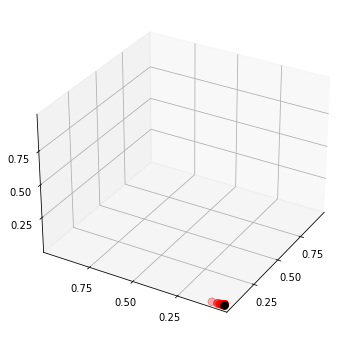

In [85]:
P = np.array(pos_array)

ψ = pos_array[1] #(0.0, 0.2, 0.8)        # Initial condition

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.set(xlim=(0, 1), ylim=(0, 1), zlim=(0, 1),
       xticks=(0.25, 0.5, 0.75),
       yticks=(0.25, 0.5, 0.75),
       zticks=(0.25, 0.5, 0.75))

x_vals, y_vals, z_vals = [], [], []
for t in range(20):
    x_vals.append(ψ[0])
    y_vals.append(ψ[1])
    z_vals.append(ψ[2])
    ψ = ψ @ P

ax.scatter(x_vals, y_vals, z_vals, c='r', s=60)
ax.view_init(30, 210)

mc = qe.MarkovChain(P)
ψ_star = mc.stationary_distributions[0]
ax.scatter(ψ_star[0], ψ_star[1], ψ_star[2], c='k', s=60)

plt.show()